## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import os
from os.path import basename

%matplotlib inline

##1a) Camera Calibration - Load Images

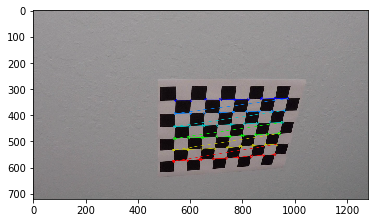

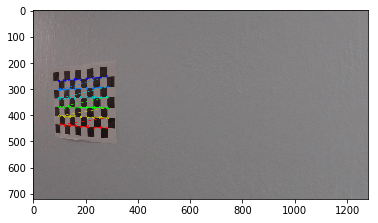

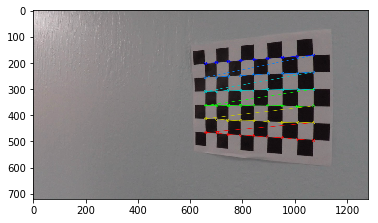

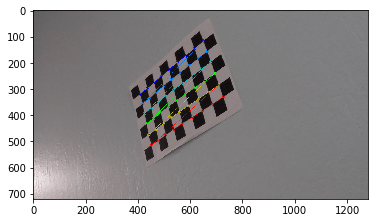

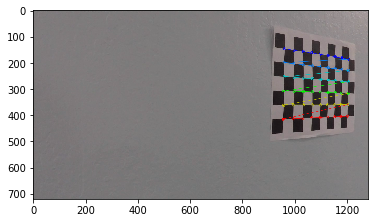

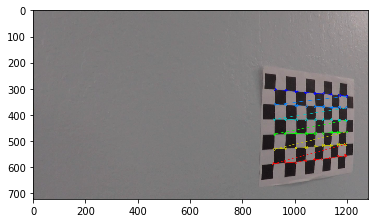

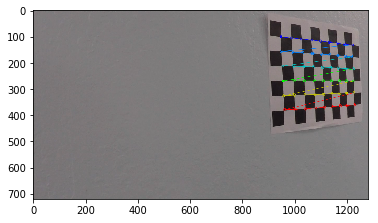

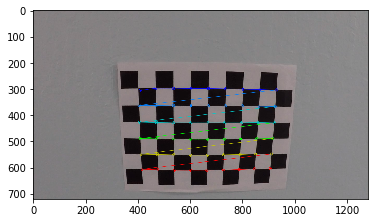

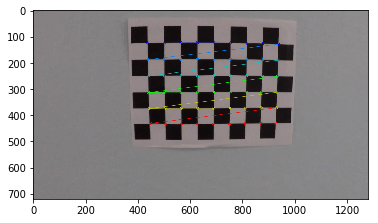

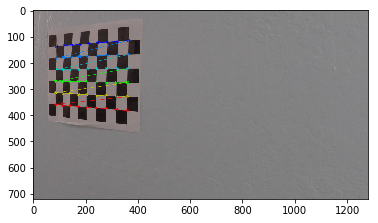

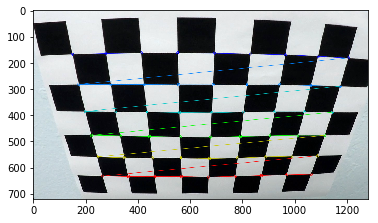

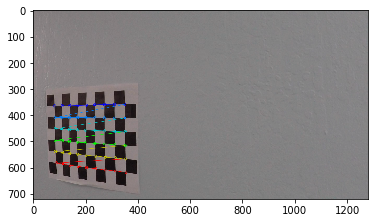

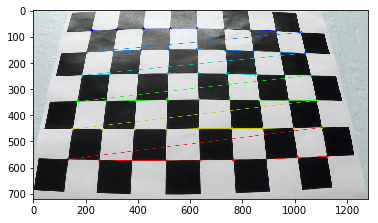

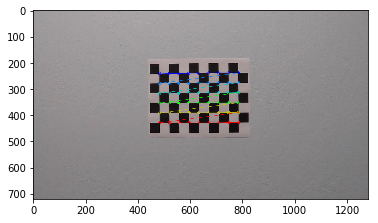

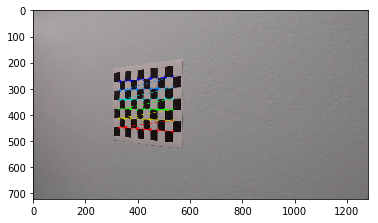

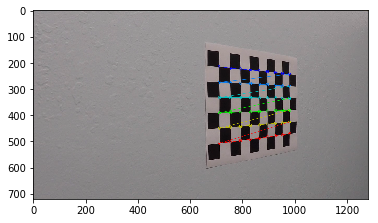

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        if True:
            rootname = os.path.splitext(basename(fname))[0]
            #print(rootname)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imwrite('./output_images/chessboard/' + rootname +'_Chessboard.jpg', img)
            plt.figure()
            plt.imshow(img)

##1) Camera Calibration - Actual Calibration

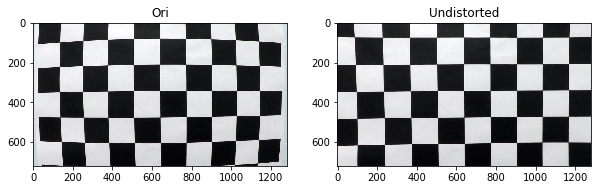

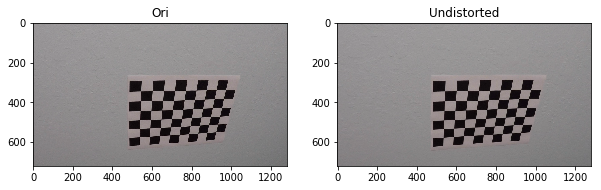

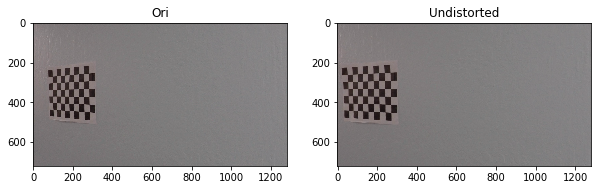

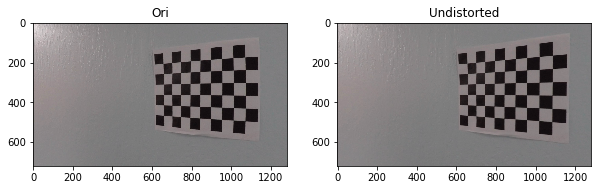

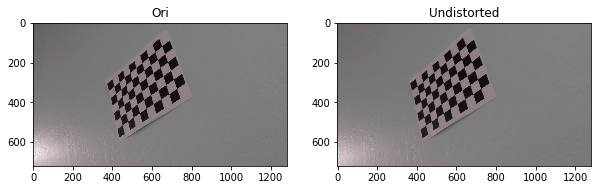

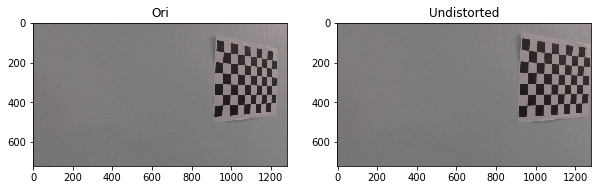

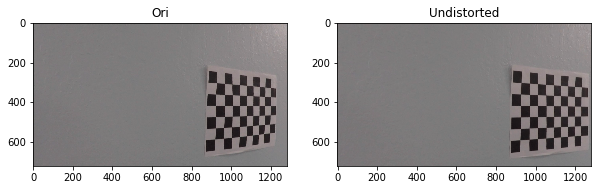

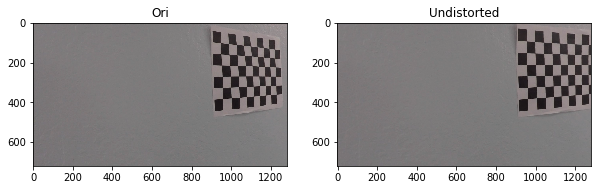

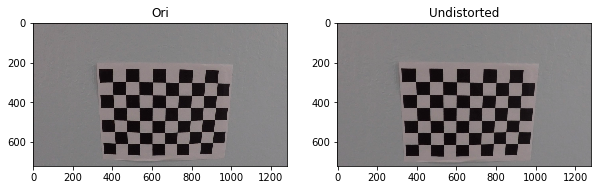

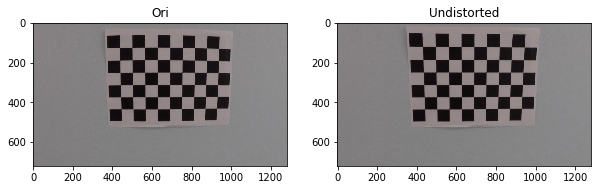

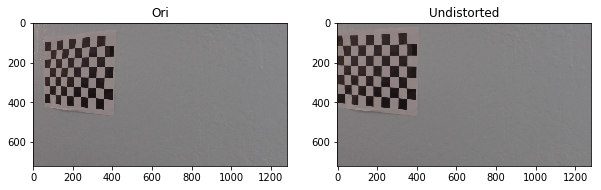

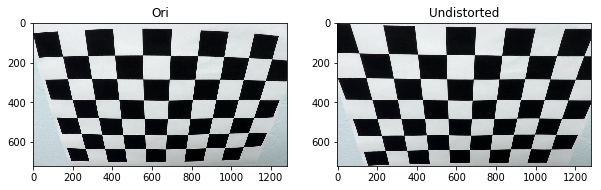

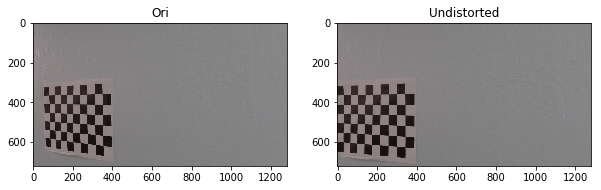

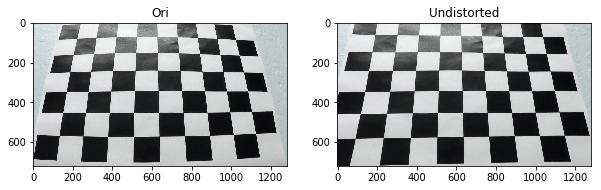

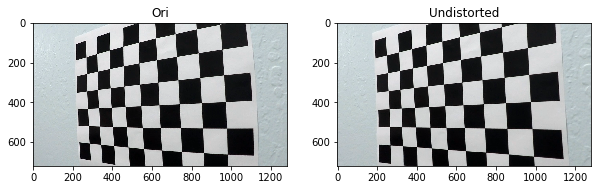

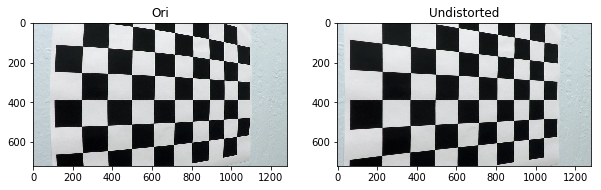

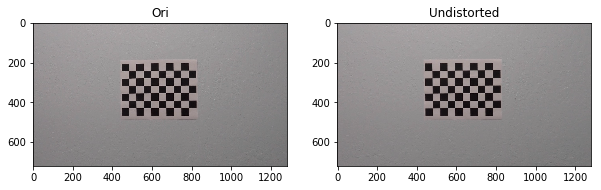

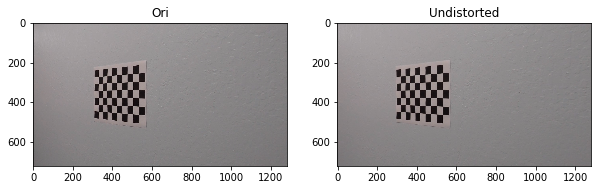

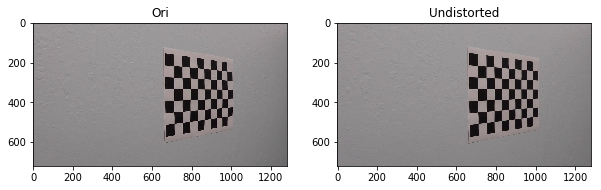

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,(img.shape[1],img.shape[0]),None, None)

for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    rootname = os.path.splitext(basename(fname))[0]
    cv2.imwrite('./output_images/undistorted/' + rootname +'_ChessboardUndistorted.jpg', dst)
    
    if True:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.imshow(img)
        ax1.set_title('Ori')
        ax2.imshow(dst)
        ax2.set_title('Undistorted')

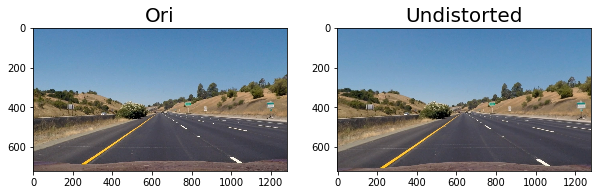

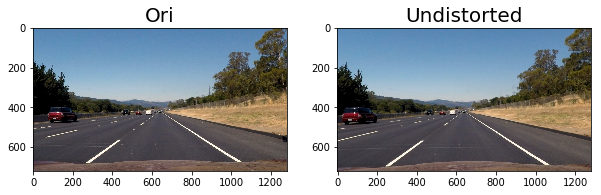

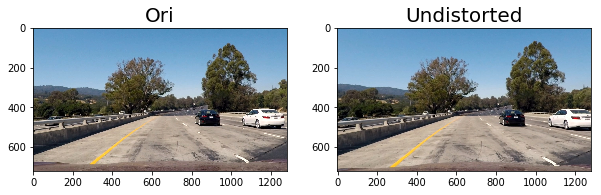

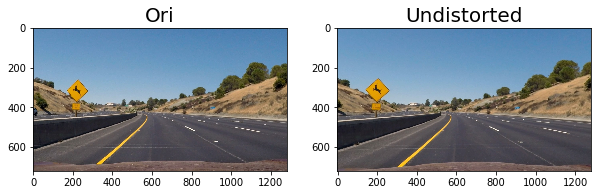

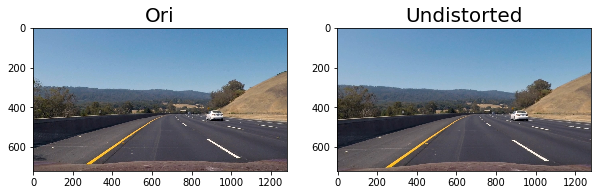

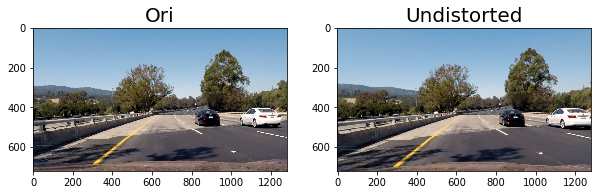

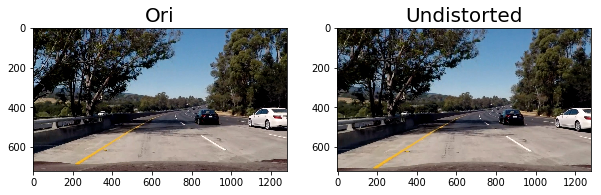

In [4]:
test_images = []
test_images_unsorted = []

images = glob.glob('test_images/*.jpg')

for fname in images:
    #print(fname)
    img = mpimg.imread(fname)
    test_images.append(img)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    test_images_unsorted.append(dst)
    
    rootname = os.path.splitext(basename(fname))[0]
    cv2.imwrite('./output_images/undistorted/' + rootname +'_Undistorted.jpg', cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))
    if True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(img)
        ax1.set_title('Ori', fontsize=20)
        ax2.imshow(dst)
        ax2.set_title('Undistorted', fontsize=20)
    

Check Projection

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    plt.imshow(sx_binary,cmap='gray')
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sx_binary

In [6]:
def perspective_swap(img, swap_back=False, draw_regions=False, plot_enable=False):
    img_size = [img.shape[1],img.shape[0]]
    
    srcpts = np.array(
        # Prespecified Lane
        #[[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        #[((img_size[0] / 6) - 10), img_size[1]],
        #[(img_size[0] * 5 / 6) + 60, img_size[1]],
        #[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        
        # Adjusted, Prespecified Lane
        #[[(img_size[0] / 2) - 58, img_size[1] / 2 + 100],
        #[((img_size[0] / 6) - 10), img_size[1]],
        #[(img_size[0] * 5 / 6) + 55, img_size[1]],
        #[(img_size[0] / 2 + 64), img_size[1] / 2 + 100]])
        
        # Narrow Lane
        [[(img_size[0] / 2) - 50, img_size[1] / 2 + 100],
        [((img_size[0] / 6) + 80), img_size[1]],
        [(img_size[0] * 5 / 6) - 30, img_size[1]],
        [(img_size[0] / 2 + 50), img_size[1] / 2 + 100]])

    dstpts = np.array(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
       
    if swap_back: 
        M = cv2.getPerspectiveTransform(np.float32([dstpts]), np.float32([srcpts]))
    else:
        M = cv2.getPerspectiveTransform(np.float32([srcpts]), np.float32([dstpts]))
    
    dst = cv2.warpPerspective(img, M, (img_size[0],img_size[1]), flags=cv2.INTER_LINEAR)
    
    dst2 = cv2.polylines(np.copy(dst), np.int32([dstpts]), 2, (255,0,0), thickness=3)
    img2 = cv2.polylines(np.copy(img), np.int32([srcpts]), 2, (255,0,0), thickness=3)
    
    if plot_enable:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Ori', fontsize=20)
        ax2.set_title('Transform', fontsize=20)
        
        if draw_regions:
            ax1.imshow(img2)
            ax2.imshow(dst2)
        else:
            ax1.imshow(img)
            ax2.imshow(dst)
            
    return dst

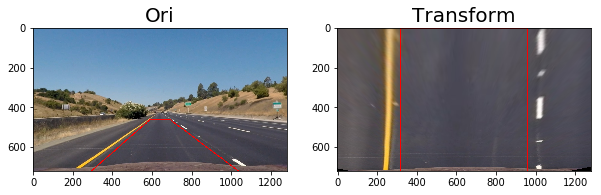

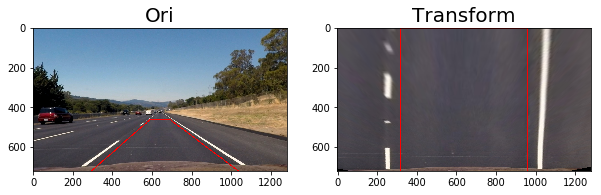

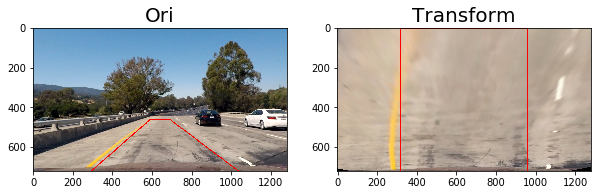

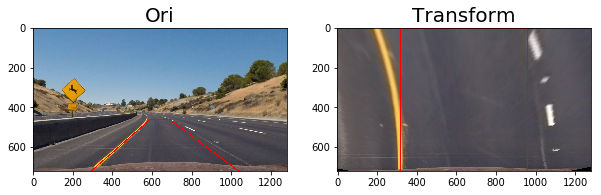

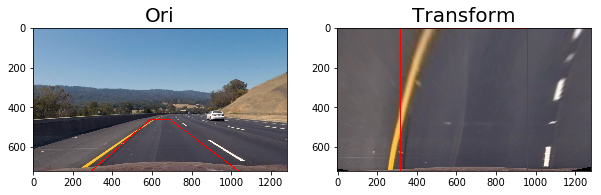

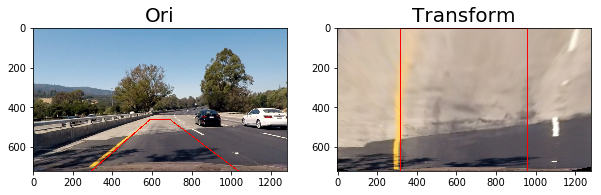

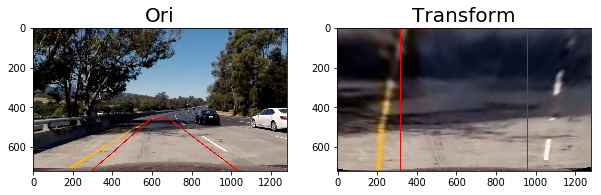

In [7]:
img_project_to = []

for cur_img in test_images_unsorted:
    dst = perspective_swap(cur_img,draw_regions=True,plot_enable=True)
    img_project_to.append(dst)

   


In [8]:
def conv2LSBinary(img, s_thresh = (170,255),sx_thresh=(20,100), sy_thresh=(20,100)):
    
    #Gray Image for Sobel
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #Sobel X
    sx = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sx = np.absolute(sx)
    sx_scaled = np.uint8(255*sx/np.max(sx))
    sx_binary = np.zeros_like(sx_scaled)
    sx_binary[(sx_scaled >= sx_thresh[0]) & (sx_scaled <= sx_thresh[1])] = 1
    
    #Sobel Y
    #sy = cv2.Sobel(gray,cv2.CV_64F,0,1)
    #sy = np.absolute(sy)
    #sy_scaled = np.uint8(255*sy/np.max(sy))
    #sy_binary = np.zeros_like(sy_scaled)
    #sy_binary[(sy_scaled >= sy_thresh[0]) & (sy_scaled <= sy_thresh[1])] = 1
    
    #Extract Saturation
    img_hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    luminance = img_hls[:,:,1]
    saturation = img_hls[:,:,2]
    l_thresh = (100,255)
    
    #Saturation Thresholding
    lum = np.absolute(luminance)
    #sat_scaled = np.uint8(255*sat/np.max(sat))
    lum_bin = np.zeros_like(lum)
    lum_bin[(lum >= l_thresh[0]) & (lum <= l_thresh[1])] = 1
    
    #Saturation Thresholding
    sat = np.absolute(saturation)
    #sat_scaled = np.uint8(255*sat/np.max(sat))
    saturation_bin = np.zeros_like(sat)
    saturation_bin[(sat >= s_thresh[0]) & (sat <= s_thresh[1])] = 1
    
    #Combine Thresholds
    sxy_binary = np.zeros_like(sx_binary)
    sxy_binary[((sx_binary==1) | (saturation_bin==1)) & (lum_bin==1)] = 1
    
    return sxy_binary


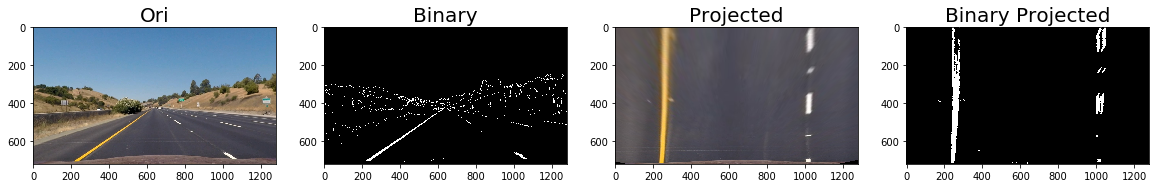

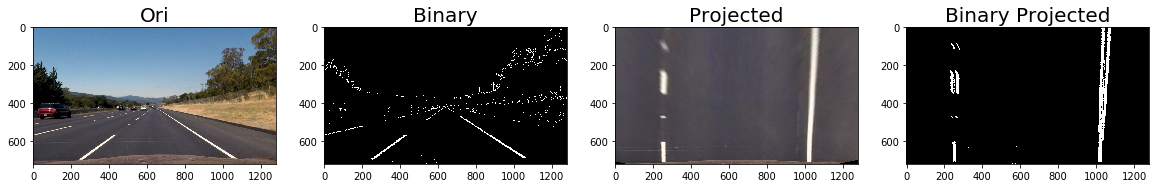

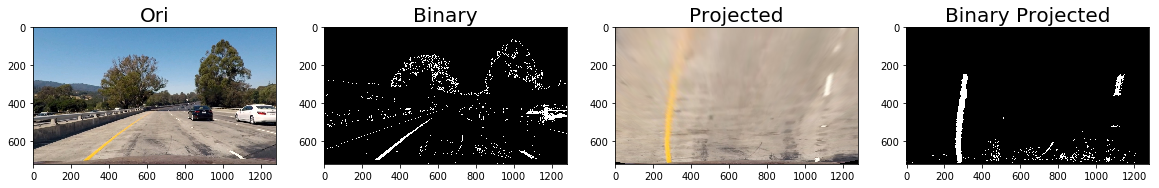

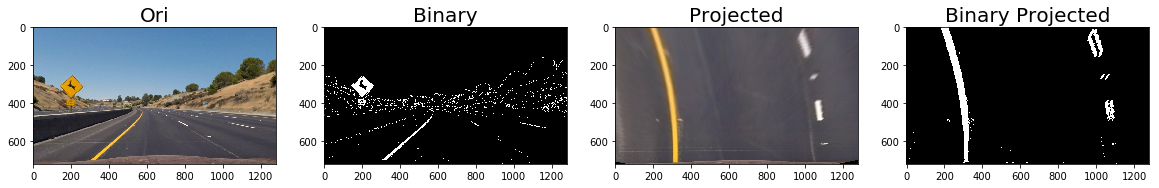

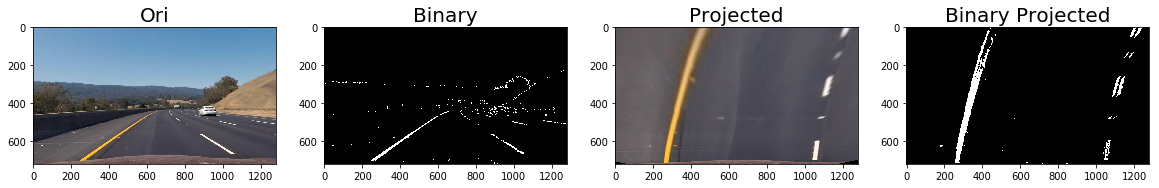

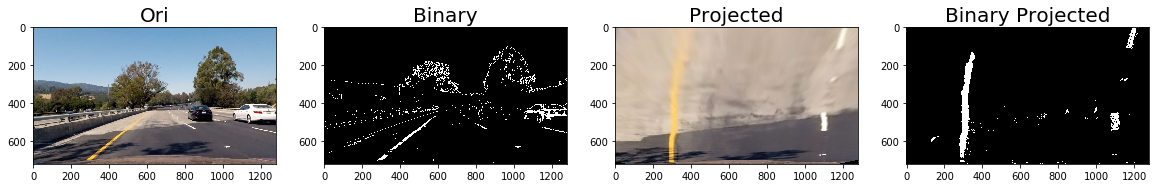

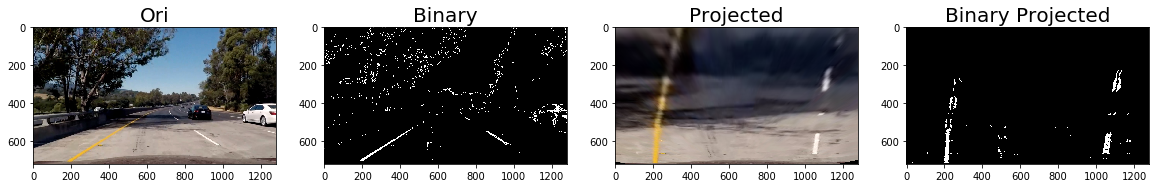

In [9]:
bin_warp_imgs = []

for cur_img, cur_img_proj in zip(test_images_unsorted, img_project_to):
    img_out_bin = conv2LSBinary(cur_img)
    img_out_projected_Bin = conv2LSBinary(cur_img_proj)
    bin_warp_imgs.append(img_out_projected_Bin)
    if True:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
        ax1.set_title('Ori', fontsize=20)
        ax1.imshow(cur_img)
        ax2.set_title('Binary', fontsize=20)
        ax2.imshow(img_out_bin, cmap='gray')
        ax3.set_title('Projected', fontsize=20)
        ax3.imshow(cur_img_proj, cmap='gray')
        ax4.set_title('Binary Projected', fontsize=20)
        ax4.imshow(img_out_projected_Bin, cmap='gray')

In [10]:
def calc_curve_radius(limits,center):
    laneleft = limits[0]
    laneright = limits[1]
    
    ploty = np.linspace(0, 719, num=720)
    
    leftx = laneleft[0]*ploty**2 + laneleft[1]*ploty + laneleft[2]
    rightx = laneright[0]*ploty**2 + laneright[1]*ploty + laneright[2] 
    
    ym_per_pix = 30./720. # meters per pixel in y dimension
    xm_per_pix = 3.7/700. # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    left_radius = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_radius = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radius
    left_curverad = ((1 + (2*left_radius[0]*y_eval*ym_per_pix + left_radius[1])**2)**1.5) / np.absolute(2*left_radius[0])
    right_curverad = ((1 + (2*right_radius[0]*y_eval*ym_per_pix + right_radius[1])**2)**1.5) / np. absolute(2*right_radius[0])
    
    cam_pos2ctr = ((leftx[int(y_eval)] + rightx[int(y_eval)])/2 - center)*xm_per_pix
    return (left_curverad,right_curverad,cam_pos2ctr)

In [11]:
def detect_lane_edges(bin_warped_img, plot_enable=False):
    output_img = np.dstack((bin_warped_img,bin_warped_img,bin_warped_img))*255
    histogram = np.sum(bin_warped_img[int(bin_warped_img.shape[0]/2):,:], axis=0)
    histograminv = bin_warped_img.shape[0] - histogram
    
    window_count = 9
    window_height = bin_warped_img.shape[0] / window_count
    window_height = int(window_height)
    window_deltaX = 100
    
    midpoint = np.int(histogram.shape[0]/2)
    
    left_window_anchor = np.argmax(histogram[:midpoint])
    right_window_anchor = np.argmax(histogram[midpoint:]) + midpoint
    
    # Multiple Windows worth of px for polyfit
    left_lane_inds = []
    right_lane_inds = []
    
    nonzero = bin_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    for cur_win in range(window_count):
        # Shared Top / Bottom
        bottom = bin_warped_img.shape[0] - window_height * (cur_win + 1)
        top = bin_warped_img.shape[0] - window_height * (cur_win)
        
        # L/R for Left Window
        Lleft = int(left_window_anchor) - window_deltaX
        Lright = int(left_window_anchor) + window_deltaX
        
        cv2.rectangle(output_img,(Lright,bottom),(Lleft,top),color=(0,255,0),thickness=2)
        Lvalidpx = ((nonzeroy < top) & (nonzeroy > bottom) & (nonzerox > Lleft) & (nonzerox < Lright)).nonzero()[0]
        left_lane_inds.append(Lvalidpx)
        if len(Lvalidpx) > 100:
            left_window_anchor = np.int(np.mean(nonzerox[Lvalidpx]))
        
        # L/R for Right Window
        Rleft = int(right_window_anchor) - window_deltaX
        Rright = int(right_window_anchor) + window_deltaX
        
        cv2.rectangle(output_img,(Rright,bottom),(Rleft,top),color=(0,255,0),thickness=2)
        Rvalidpx = ((nonzeroy < top) & (nonzeroy > bottom) & (nonzerox > Rleft) & (nonzerox < Rright)).nonzero()[0]
        right_lane_inds.append(Rvalidpx)
        if len(Rvalidpx) > 100:
            right_window_anchor = np.int(np.mean(nonzerox[Rvalidpx]))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #Fit the lines
    left_line = np.polyfit(nonzeroy[left_lane_inds], nonzerox[left_lane_inds], 2)
    right_line = np.polyfit(nonzeroy[right_lane_inds], nonzerox[right_lane_inds], 2)
    
    lanedata = calc_curve_radius((left_line,right_line),bin_warped_img.shape[1]/2)
    
    ploty = np.linspace(0, bin_warped_img.shape[0]-1, bin_warped_img.shape[0])
    left_fitx = left_line[0]*ploty**2 + left_line[1]*ploty + left_line[2]
    right_fitx = right_line[0]*ploty**2 + right_line[1]*ploty + right_line[2]
    
    #Used Left px == blue
    output_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #Used Right px == blue
    output_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
 
    if plot_enable:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
        ax1.set_title('Ori', fontsize=20)
        ax1.imshow(bin_warped_img, cmap='gray')
        ax2.imshow(bin_warped_img, cmap='gray')
        ax2.imshow(output_img)
        ax2.plot(histograminv, color='pink')
        ax2.plot(left_fitx,ploty, color='c')
        ax2.plot(right_fitx,ploty, color='c')
        
    return (left_line,right_line),lanedata


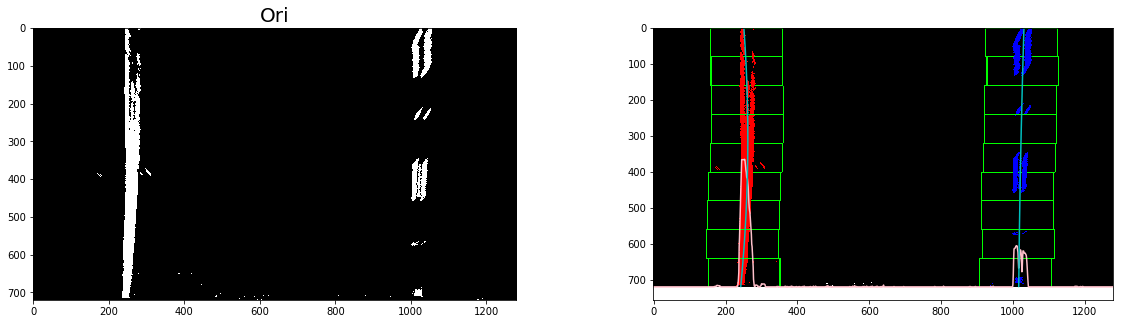

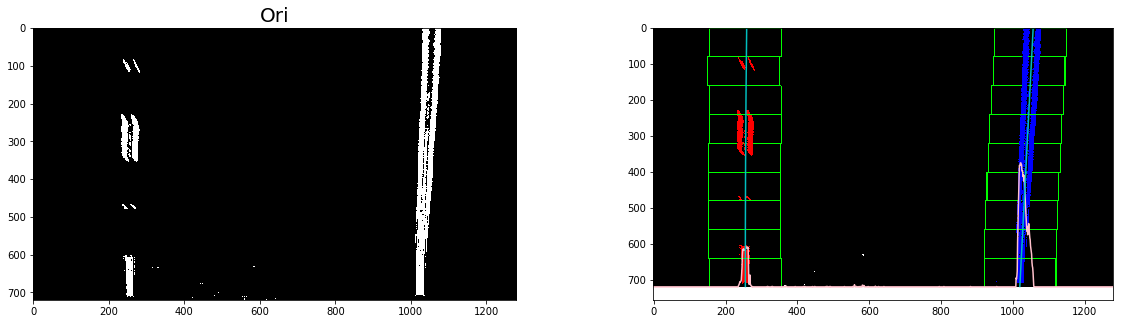

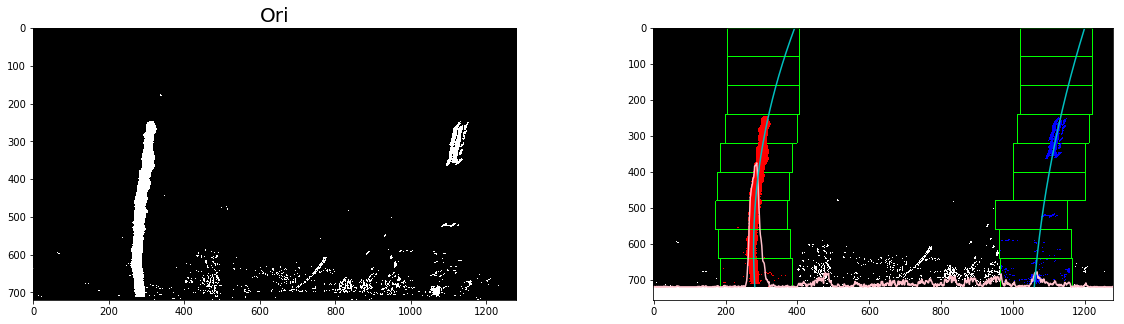

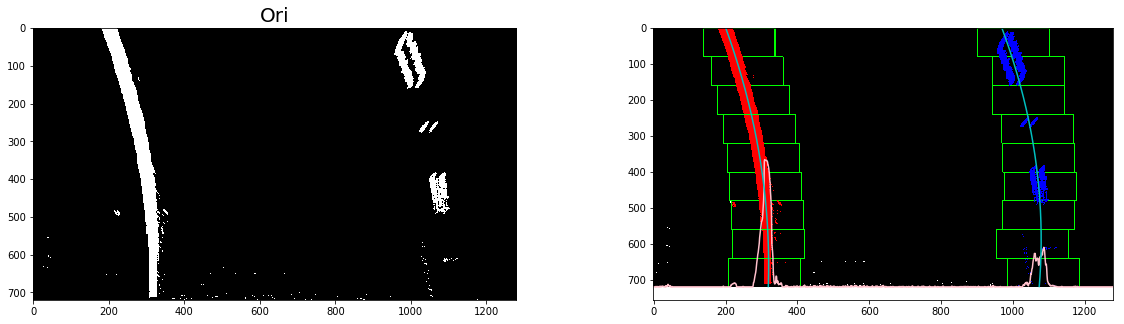

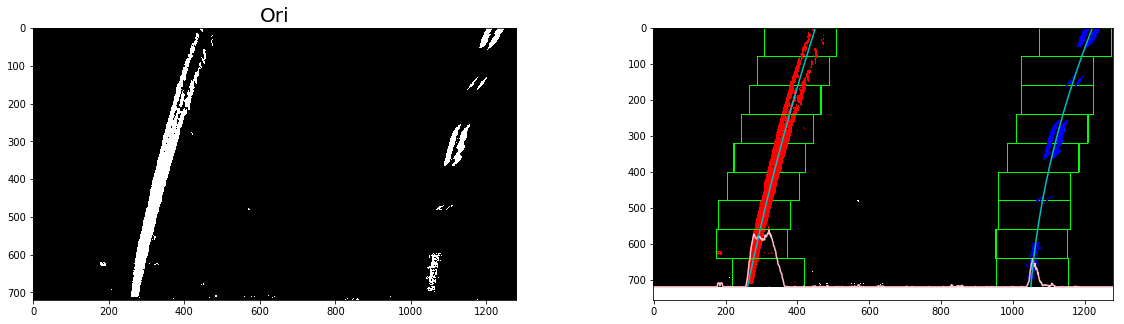

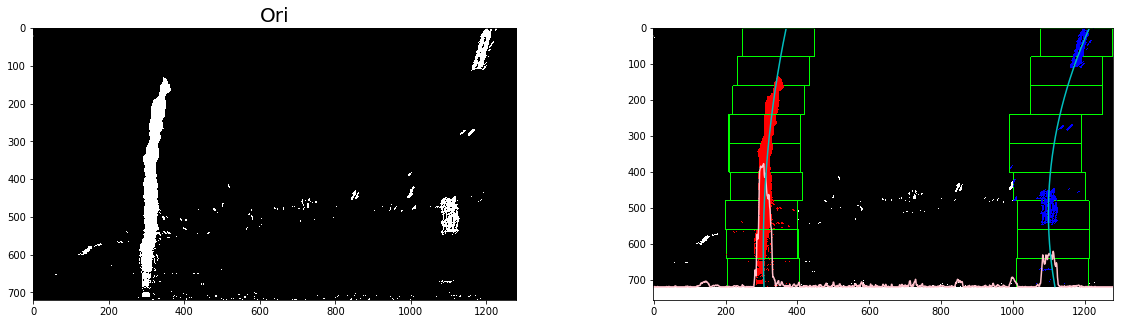

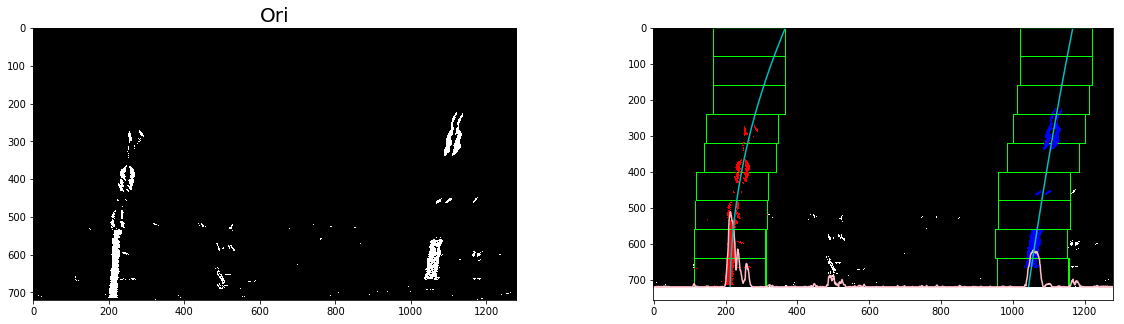

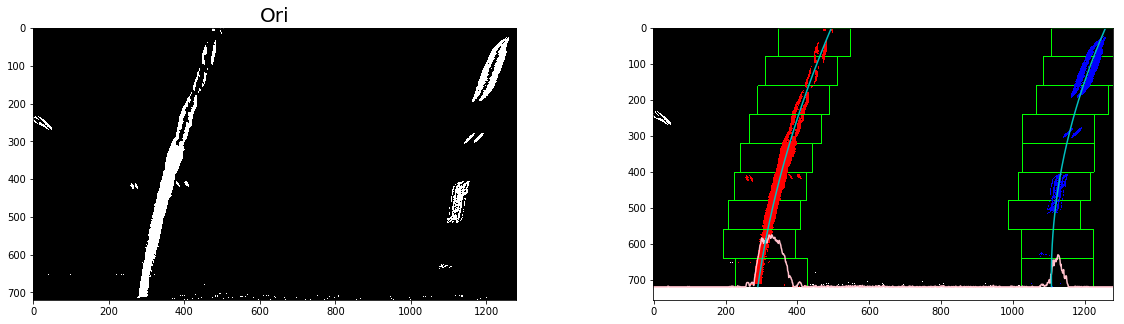

In [12]:
detectedLanes = []
for img in bin_warp_imgs:
    detectedLanes.append(detect_lane_edges(img, plot_enable=True))
    

In [13]:
def LanePoly(img,plot_enable=False, display_curve_radius=True):
    
    limits,crText = detect_lane_edges(img)
    
    laneleft = limits[0]
    laneright = limits[1]
    
    ploty = np.linspace(0,img.shape[0]-1, img.shape[0])
    leftcoords = laneleft[0]*ploty**2 + laneleft[1]*ploty + laneleft[2]
    rightcoords = laneright[0]*ploty**2 + laneright[1]*ploty + laneright[2] 
    
    left = np.dstack((leftcoords,ploty))
    right = np.fliplr(np.dstack((rightcoords, ploty)))
    cmb = np.hstack((left,right)).astype('int')
    
    img_mask = np.zeros_like(img)
    cv2.fillPoly(img_mask,cmb,255)
    img_masked = cv2.bitwise_and(np.ones_like(img),img_mask)
    
    img_out = np.dstack(( np.zeros_like(img),img_masked*255,np.zeros_like(img)))
    
    #crText = calc_curve_radius(limits,img.shape[1]/2)
 
    if plot_enable:    
        plt.figure()
        plt.imshow(img_out)
            
        plt.show()
    
    return img_out, crText


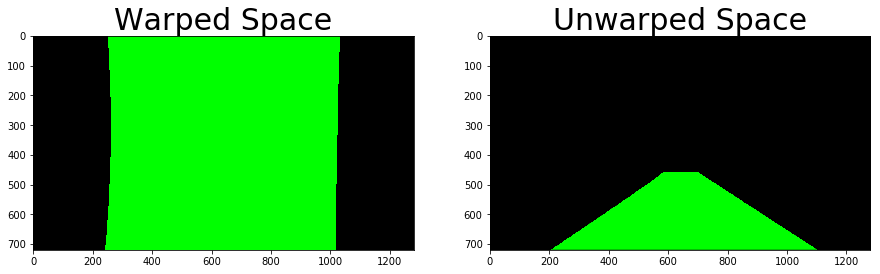

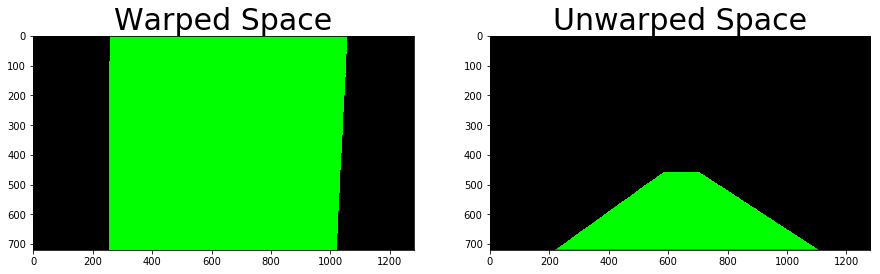

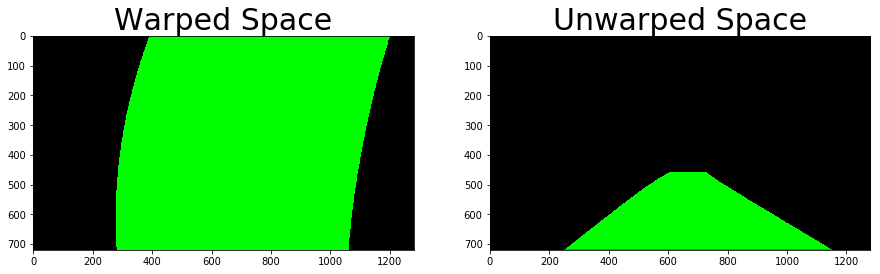

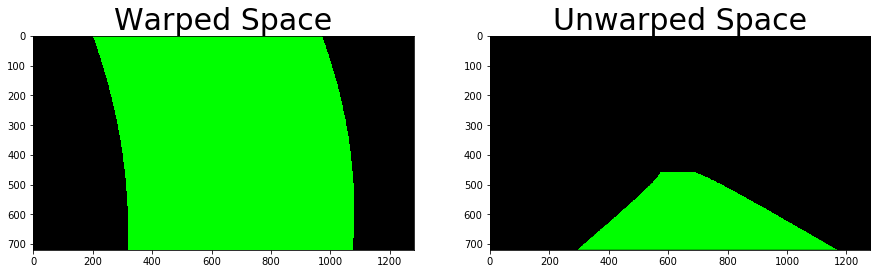

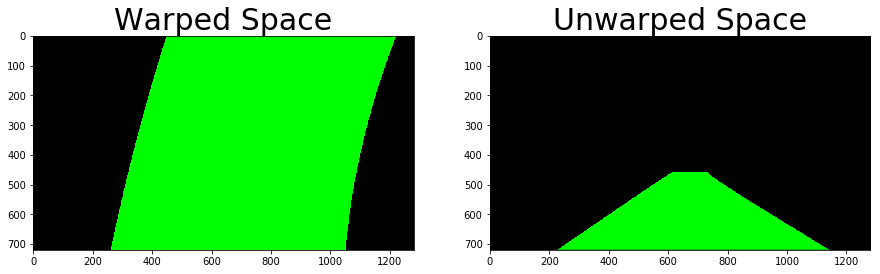

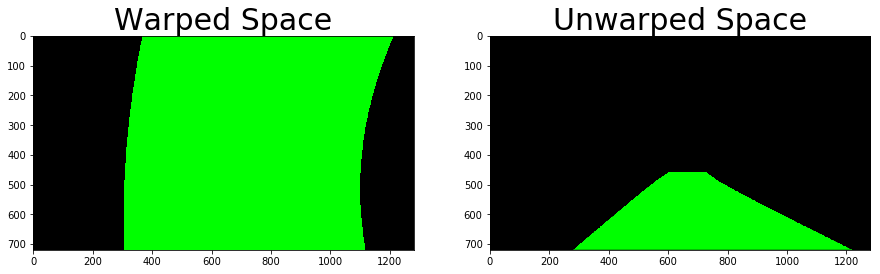

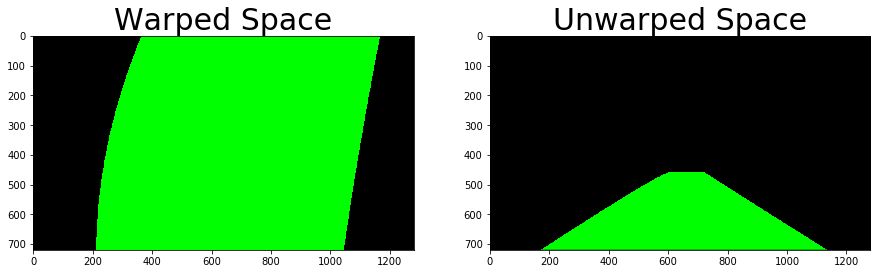

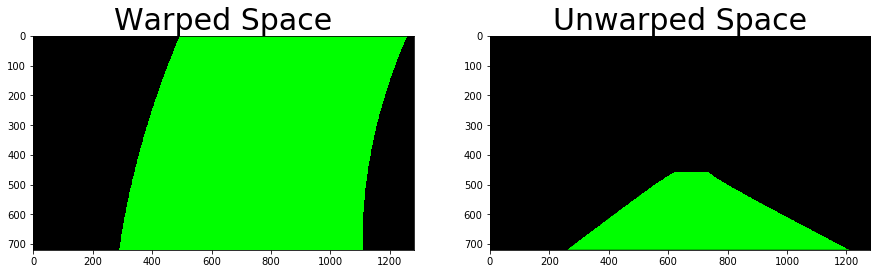

In [14]:
img_lane_masks = []
for img in bin_warp_imgs:
    img_warped, radius = LanePoly(img)
    
    img_warped_back = perspective_swap(img_warped, swap_back=True)
    img_lane_masks.append(img_warped_back)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    ax1.set_title('Warped Space', fontsize=30)
    ax1.imshow(img_warped)
    ax2.set_title('Unwarped Space', fontsize=30)
    ax2.imshow(img_warped_back)

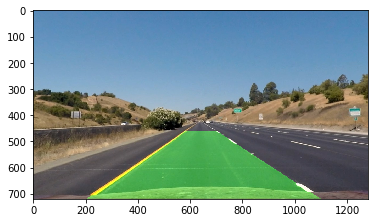

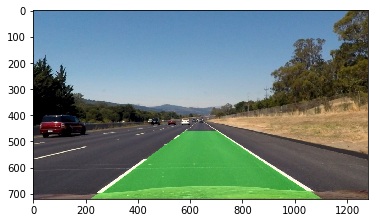

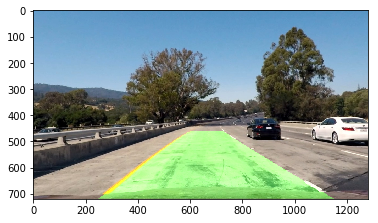

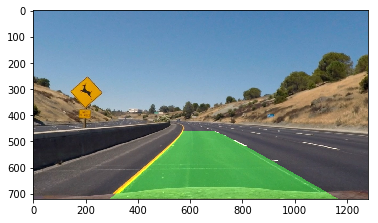

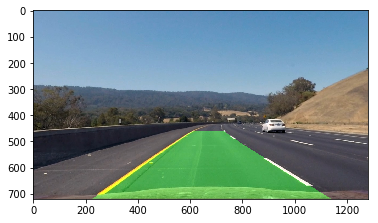

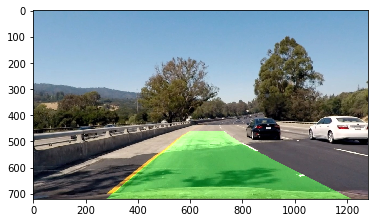

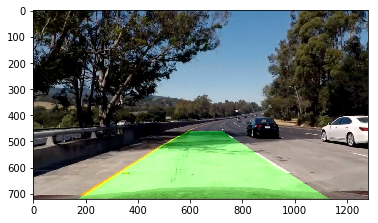

In [15]:
for img,overlay in zip(test_images_unsorted,img_lane_masks):
    img_overlayed = cv2.addWeighted(img, 1, overlay, 0.4, 0.0)
    if True:
        plt.figure()
        plt.imshow(img_overlayed)
    

In [16]:
def DisplayText(img, data):
    cv2.putText(img,'Left Radius: %d(m)'%data[0],(50,50),cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)
    cv2.putText(img,'Right Radius: %d(m)'%data[1],(850,50),cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)
    cv2.putText(img,'Cam Lane Pos: {0:.3f}(m)'.format(data[2]),(400,100),cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)
    pass

In [17]:
def LineFinder(img):
    
    #Undistort incoming frame
    img_undist = cv2.undistort(img,mtx,dist,None,mtx)
    
    #Warp image to birdseye view
    img_be = perspective_swap(img_undist)
    
    #Binary Threshold the Warped image
    img_be_bin = conv2LSBinary(img_be)
    
    #Detect Lane edges
    img_warped, data = LanePoly(img_be_bin)
    
    #Warp the Lane back to normal coordinates
    img_warped_back = perspective_swap(img_warped, swap_back=True)
    
    #Overlay calculated lane on original image
    img_overlayed = cv2.addWeighted(img_undist, 1, img_warped_back, 0.4, 0.0)
    
    #Overlay radius and car position in lane
    DisplayText(img_overlayed,data)
    
    if False:
        f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,30))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax1.imshow(img_undist)
        ax2.set_title('Warped Image', fontsize=20)
        ax2.imshow(img_be)
        
        f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,30))
        ax1.set_title('Warped Thresh Image', fontsize=20)
        ax1.imshow(img_be_bin, cmap='gray')
        ax2.set_title('Lane Lines Warped', fontsize=20)
        ax2.imshow(img_warped)
        
        f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,30))
        ax1.set_title('Unwarped Thresh Image', fontsize=20)
        ax1.imshow(img_warped_back, cmap='gray')
        ax2.set_title('Final Frame', fontsize=20)
        ax2.imshow(img_overlayed)
 
    return img_overlayed

In [18]:
tmp = LineFinder(test_images[0])


In [24]:
project_output_file = "project_output.mp4"
project_video = VideoFileClip("./project_video.mp4")
project_output = project_video.fl_image(LineFinder)
%time project_output.write_videofile(project_output_file, audio=False)

[MoviePy] >>>> Building video project_output.mp4


[MoviePy] Writing video project_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:32,  8.26it/s]

  0%|          | 2/1261 [00:00<02:27,  8.52it/s]

  0%|          | 3/1261 [00:00<02:27,  8.52it/s]

  0%|          | 4/1261 [00:00<02:22,  8.82it/s]

  0%|          | 5/1261 [00:00<02:19,  8.97it/s]

  0%|          | 6/1261 [00:00<02:15,  9.23it/s]

  1%|          | 7/1261 [00:00<02:13,  9.37it/s]

  1%|          | 8/1261 [00:00<02:15,  9.23it/s]

  1%|          | 9/1261 [00:00<02:13,  9.37it/s]

  1%|          | 10/1261 [00:01<02:11,  9.50it/s]

  1%|          | 11/1261 [00:01<02:10,  9.56it/s]

  1%|          | 12/1261 [00:01<02:10,  9.55it/s]

  1%|          | 13/1261 [00:01<02:11,  9.51it/s]

  1%|          | 14/1261 [00:01<02:11,  9.46it/s]

  1%|          | 15/1261 [00:01<02:11,  9.51it/s]

  1%|▏         | 16/1261 [00:01<02:09,  9.59it/s]

  1%|▏         | 17/1261 [00:01<02:09,  9.57it/s]

  1%|▏         | 18/1261 [00:01<02:13,  9.32it/s]

  2%|▏         | 19/1261 [00:02<02:12,  9.35it/s]

  2%|▏         | 20/1261 [00:02<02:11,  9.45it/s]

  2%|▏         | 21/1261 [00:02<02:12,  9.37it/s]

  2%|▏         | 22/1261 [00:02<02:11,  9.44it/s]

  2%|▏         | 23/1261 [00:02<02:25,  8.50it/s]

  2%|▏         | 24/1261 [00:02<02:26,  8.45it/s]

  2%|▏         | 25/1261 [00:02<02:28,  8.31it/s]

  2%|▏         | 27/1261 [00:02<02:19,  8.87it/s]

  2%|▏         | 29/1261 [00:03<02:11,  9.37it/s]

  2%|▏         | 31/1261 [00:03<02:06,  9.71it/s]

  3%|▎         | 33/1261 [00:03<02:03,  9.95it/s]

  3%|▎         | 35/1261 [00:03<02:00, 10.13it/s]

  3%|▎         | 37/1261 [00:03<01:58, 10.31it/s]

  3%|▎         | 39/1261 [00:04<01:57, 10.41it/s]

  3%|▎         | 41/1261 [00:04<01:58, 10.33it/s]

  3%|▎         | 43/1261 [00:04<01:56, 10.48it/s]

  4%|▎         | 45/1261 [00:04<01:56, 10.45it/s]

  4%|▎         | 47/1261 [00:04<01:57, 10.32it/s]

  4%|▍         | 49/1261 [00:05<01:59, 10.15it/s]

  4%|▍         | 51/1261 [00:05<01:59, 10.16it/s]

  4%|▍         | 53/1261 [00:05<01:58, 10.17it/s]

  4%|▍         | 55/1261 [00:05<01:59, 10.07it/s]

  5%|▍         | 57/1261 [00:05<02:00, 10.01it/s]

  5%|▍         | 59/1261 [00:06<01:58, 10.13it/s]

  5%|▍         | 61/1261 [00:06<01:58, 10.12it/s]

  5%|▍         | 63/1261 [00:06<02:01,  9.86it/s]

  5%|▌         | 64/1261 [00:06<02:04,  9.64it/s]

  5%|▌         | 66/1261 [00:06<02:01,  9.86it/s]

  5%|▌         | 68/1261 [00:06<01:59,  9.98it/s]

  6%|▌         | 70/1261 [00:07<01:57, 10.13it/s]

  6%|▌         | 72/1261 [00:07<01:55, 10.28it/s]

  6%|▌         | 74/1261 [00:07<01:56, 10.21it/s]

  6%|▌         | 76/1261 [00:07<01:56, 10.16it/s]

  6%|▌         | 78/1261 [00:07<01:56, 10.17it/s]

  6%|▋         | 80/1261 [00:08<01:55, 10.24it/s]

  7%|▋         | 82/1261 [00:08<01:54, 10.26it/s]

  7%|▋         | 84/1261 [00:08<01:55, 10.21it/s]

  7%|▋         | 86/1261 [00:08<01:54, 10.30it/s]

  7%|▋         | 88/1261 [00:08<01:53, 10.31it/s]

  7%|▋         | 90/1261 [00:09<01:53, 10.29it/s]

  7%|▋         | 92/1261 [00:09<01:53, 10.30it/s]

  7%|▋         | 94/1261 [00:09<01:52, 10.40it/s]

  8%|▊         | 96/1261 [00:09<01:52, 10.37it/s]

  8%|▊         | 98/1261 [00:09<01:52, 10.38it/s]

  8%|▊         | 100/1261 [00:10<01:52, 10.30it/s]

  8%|▊         | 102/1261 [00:10<01:52, 10.35it/s]

  8%|▊         | 104/1261 [00:10<01:51, 10.42it/s]

  8%|▊         | 106/1261 [00:10<01:50, 10.43it/s]

  9%|▊         | 108/1261 [00:10<01:50, 10.43it/s]

  9%|▊         | 110/1261 [00:10<01:50, 10.44it/s]

  9%|▉         | 112/1261 [00:11<01:50, 10.38it/s]

  9%|▉         | 114/1261 [00:11<01:49, 10.47it/s]

  9%|▉         | 116/1261 [00:11<01:51, 10.29it/s]

  9%|▉         | 118/1261 [00:11<01:52, 10.14it/s]

 10%|▉         | 120/1261 [00:11<01:51, 10.21it/s]

 10%|▉         | 122/1261 [00:12<01:50, 10.27it/s]

 10%|▉         | 124/1261 [00:12<01:49, 10.34it/s]

 10%|▉         | 126/1261 [00:12<01:48, 10.48it/s]

 10%|█         | 128/1261 [00:12<01:47, 10.53it/s]

 10%|█         | 130/1261 [00:12<01:47, 10.49it/s]

 10%|█         | 132/1261 [00:13<01:48, 10.45it/s]

 11%|█         | 134/1261 [00:13<01:48, 10.42it/s]

 11%|█         | 136/1261 [00:13<01:47, 10.42it/s]

 11%|█         | 138/1261 [00:13<01:51, 10.07it/s]

 11%|█         | 140/1261 [00:13<01:50, 10.14it/s]

 11%|█▏        | 142/1261 [00:14<01:49, 10.18it/s]

 11%|█▏        | 144/1261 [00:14<01:51, 10.05it/s]

 12%|█▏        | 146/1261 [00:14<01:51, 10.00it/s]

 12%|█▏        | 148/1261 [00:14<01:50, 10.08it/s]

 12%|█▏        | 150/1261 [00:14<01:49, 10.17it/s]

 12%|█▏        | 152/1261 [00:15<01:57,  9.42it/s]

 12%|█▏        | 153/1261 [00:15<01:57,  9.45it/s]

 12%|█▏        | 154/1261 [00:15<01:55,  9.55it/s]

 12%|█▏        | 155/1261 [00:15<01:54,  9.68it/s]

 12%|█▏        | 156/1261 [00:15<01:55,  9.55it/s]

 13%|█▎        | 158/1261 [00:15<01:53,  9.71it/s]

 13%|█▎        | 159/1261 [00:15<01:54,  9.65it/s]

 13%|█▎        | 160/1261 [00:16<06:01,  3.04it/s]

 13%|█▎        | 161/1261 [00:16<05:10,  3.54it/s]

 13%|█▎        | 162/1261 [00:16<04:13,  4.34it/s]

 13%|█▎        | 164/1261 [00:17<03:53,  4.70it/s]

 13%|█▎        | 165/1261 [00:17<03:22,  5.41it/s]

 13%|█▎        | 166/1261 [00:17<03:00,  6.07it/s]

 13%|█▎        | 167/1261 [00:17<03:08,  5.79it/s]

 13%|█▎        | 168/1261 [00:18<06:03,  3.01it/s]

 13%|█▎        | 169/1261 [00:19<07:43,  2.36it/s]

 13%|█▎        | 170/1261 [00:19<06:01,  3.02it/s]

 14%|█▎        | 171/1261 [00:19<04:47,  3.79it/s]

 14%|█▎        | 172/1261 [00:19<04:01,  4.52it/s]

 14%|█▎        | 173/1261 [00:19<03:25,  5.28it/s]

 14%|█▍        | 174/1261 [00:19<03:05,  5.87it/s]

 14%|█▍        | 175/1261 [00:19<03:21,  5.40it/s]

 14%|█▍        | 176/1261 [00:20<04:16,  4.22it/s]

 14%|█▍        | 177/1261 [00:20<03:33,  5.08it/s]

 14%|█▍        | 178/1261 [00:20<03:03,  5.91it/s]

 14%|█▍        | 179/1261 [00:20<02:42,  6.66it/s]

 14%|█▍        | 180/1261 [00:20<02:54,  6.19it/s]

 14%|█▍        | 181/1261 [00:20<02:35,  6.95it/s]

 14%|█▍        | 182/1261 [00:20<02:21,  7.65it/s]

 15%|█▍        | 184/1261 [00:21<02:09,  8.29it/s]

 15%|█▍        | 185/1261 [00:21<02:03,  8.71it/s]

 15%|█▍        | 187/1261 [00:21<01:58,  9.08it/s]

 15%|█▍        | 188/1261 [00:21<01:57,  9.10it/s]

 15%|█▍        | 189/1261 [00:21<01:55,  9.28it/s]

 15%|█▌        | 191/1261 [00:21<01:51,  9.58it/s]

 15%|█▌        | 193/1261 [00:22<01:49,  9.76it/s]

 15%|█▌        | 195/1261 [00:22<01:48,  9.81it/s]

 16%|█▌        | 196/1261 [00:22<01:48,  9.81it/s]

 16%|█▌        | 197/1261 [00:22<01:48,  9.81it/s]

 16%|█▌        | 198/1261 [00:22<01:49,  9.72it/s]

 16%|█▌        | 200/1261 [00:22<01:48,  9.80it/s]

 16%|█▌        | 202/1261 [00:22<01:47,  9.86it/s]

 16%|█▌        | 203/1261 [00:23<01:47,  9.84it/s]

 16%|█▌        | 204/1261 [00:23<01:46,  9.89it/s]

 16%|█▋        | 205/1261 [00:23<01:46,  9.92it/s]

 16%|█▋        | 206/1261 [00:23<01:48,  9.74it/s]

 16%|█▋        | 207/1261 [00:23<01:51,  9.43it/s]

 16%|█▋        | 208/1261 [00:23<01:57,  8.97it/s]

 17%|█▋        | 209/1261 [00:23<01:53,  9.23it/s]

 17%|█▋        | 210/1261 [00:23<01:51,  9.42it/s]

 17%|█▋        | 211/1261 [00:23<01:50,  9.53it/s]

 17%|█▋        | 212/1261 [00:24<01:50,  9.53it/s]

 17%|█▋        | 213/1261 [00:24<01:51,  9.39it/s]

 17%|█▋        | 214/1261 [00:24<01:51,  9.38it/s]

 17%|█▋        | 215/1261 [00:24<01:50,  9.45it/s]

 17%|█▋        | 216/1261 [00:24<01:49,  9.55it/s]

 17%|█▋        | 217/1261 [00:24<01:50,  9.49it/s]

 17%|█▋        | 218/1261 [00:24<01:49,  9.50it/s]

 17%|█▋        | 220/1261 [00:24<01:47,  9.66it/s]

 18%|█▊        | 221/1261 [00:24<01:49,  9.48it/s]

 18%|█▊        | 222/1261 [00:25<01:53,  9.18it/s]

 18%|█▊        | 223/1261 [00:25<01:52,  9.25it/s]

 18%|█▊        | 224/1261 [00:25<01:53,  9.10it/s]

 18%|█▊        | 225/1261 [00:25<02:00,  8.60it/s]

 18%|█▊        | 226/1261 [00:25<01:57,  8.85it/s]

 18%|█▊        | 227/1261 [00:25<02:00,  8.57it/s]

 18%|█▊        | 228/1261 [00:25<02:07,  8.11it/s]

 18%|█▊        | 229/1261 [00:25<02:20,  7.34it/s]

 18%|█▊        | 230/1261 [00:26<02:09,  7.95it/s]

 18%|█▊        | 231/1261 [00:26<02:04,  8.30it/s]

 18%|█▊        | 232/1261 [00:26<02:00,  8.57it/s]

 18%|█▊        | 233/1261 [00:26<01:56,  8.85it/s]

 19%|█▊        | 234/1261 [00:26<01:54,  8.96it/s]

 19%|█▊        | 235/1261 [00:26<01:52,  9.16it/s]

 19%|█▊        | 236/1261 [00:26<02:44,  6.22it/s]

 19%|█▉        | 237/1261 [00:27<02:26,  6.97it/s]

 19%|█▉        | 239/1261 [00:27<02:13,  7.68it/s]

 19%|█▉        | 240/1261 [00:27<02:05,  8.16it/s]

 19%|█▉        | 241/1261 [00:27<01:58,  8.63it/s]

 19%|█▉        | 242/1261 [00:27<01:53,  9.00it/s]

 19%|█▉        | 243/1261 [00:27<01:49,  9.26it/s]

 19%|█▉        | 245/1261 [00:27<01:46,  9.53it/s]

 20%|█▉        | 246/1261 [00:27<01:45,  9.66it/s]

 20%|█▉        | 247/1261 [00:28<01:44,  9.74it/s]

 20%|█▉        | 249/1261 [00:28<01:42,  9.85it/s]

 20%|█▉        | 250/1261 [00:28<01:42,  9.85it/s]

 20%|█▉        | 251/1261 [00:28<01:42,  9.89it/s]

 20%|█▉        | 252/1261 [00:28<01:42,  9.89it/s]

 20%|██        | 253/1261 [00:28<01:43,  9.73it/s]

 20%|██        | 254/1261 [00:28<01:42,  9.79it/s]

 20%|██        | 256/1261 [00:28<01:40,  9.97it/s]

 20%|██        | 257/1261 [00:29<01:41,  9.89it/s]

 20%|██        | 258/1261 [00:29<01:43,  9.70it/s]

 21%|██        | 260/1261 [00:29<01:41,  9.85it/s]

 21%|██        | 261/1261 [00:29<01:41,  9.85it/s]

 21%|██        | 263/1261 [00:29<01:40,  9.91it/s]

 21%|██        | 264/1261 [00:29<01:40,  9.87it/s]

 21%|██        | 265/1261 [00:29<01:40,  9.91it/s]

 21%|██        | 267/1261 [00:30<01:39,  9.97it/s]

 21%|██▏       | 268/1261 [00:30<01:40,  9.88it/s]

 21%|██▏       | 270/1261 [00:30<01:39, 10.00it/s]

 22%|██▏       | 272/1261 [00:30<01:38, 10.00it/s]

 22%|██▏       | 274/1261 [00:30<01:38, 10.00it/s]

 22%|██▏       | 276/1261 [00:30<01:37, 10.09it/s]

 22%|██▏       | 278/1261 [00:31<01:36, 10.18it/s]

 22%|██▏       | 280/1261 [00:31<01:36, 10.15it/s]

 22%|██▏       | 282/1261 [00:31<01:35, 10.21it/s]

 23%|██▎       | 284/1261 [00:31<01:35, 10.25it/s]

 23%|██▎       | 286/1261 [00:31<01:37, 10.04it/s]

 23%|██▎       | 288/1261 [00:32<01:37,  9.95it/s]

 23%|██▎       | 290/1261 [00:32<01:37,  9.99it/s]

 23%|██▎       | 292/1261 [00:32<01:36, 10.08it/s]

 23%|██▎       | 294/1261 [00:32<01:35, 10.09it/s]

 23%|██▎       | 296/1261 [00:32<01:34, 10.18it/s]

 24%|██▎       | 298/1261 [00:33<01:34, 10.18it/s]

 24%|██▍       | 300/1261 [00:33<01:34, 10.21it/s]

 24%|██▍       | 302/1261 [00:33<01:33, 10.25it/s]

 24%|██▍       | 304/1261 [00:33<01:35, 10.03it/s]

 24%|██▍       | 306/1261 [00:33<01:36,  9.91it/s]

 24%|██▍       | 307/1261 [00:33<01:38,  9.69it/s]

 24%|██▍       | 308/1261 [00:34<01:38,  9.72it/s]

 25%|██▍       | 309/1261 [00:34<01:38,  9.64it/s]

 25%|██▍       | 310/1261 [00:34<01:38,  9.70it/s]

 25%|██▍       | 311/1261 [00:34<01:37,  9.76it/s]

 25%|██▍       | 312/1261 [00:34<01:37,  9.77it/s]

 25%|██▍       | 313/1261 [00:34<01:37,  9.72it/s]

 25%|██▍       | 314/1261 [00:34<01:36,  9.77it/s]

 25%|██▌       | 316/1261 [00:34<01:35,  9.85it/s]

 25%|██▌       | 317/1261 [00:35<01:35,  9.84it/s]

 25%|██▌       | 318/1261 [00:35<01:37,  9.68it/s]

 25%|██▌       | 319/1261 [00:35<01:39,  9.49it/s]

 25%|██▌       | 320/1261 [00:35<01:38,  9.57it/s]

 25%|██▌       | 321/1261 [00:35<01:37,  9.69it/s]

 26%|██▌       | 322/1261 [00:35<01:36,  9.73it/s]

 26%|██▌       | 323/1261 [00:35<01:36,  9.74it/s]

 26%|██▌       | 324/1261 [00:35<01:36,  9.74it/s]

 26%|██▌       | 325/1261 [00:35<01:36,  9.74it/s]

 26%|██▌       | 327/1261 [00:36<01:34,  9.86it/s]

 26%|██▌       | 328/1261 [00:36<01:34,  9.83it/s]

 26%|██▌       | 329/1261 [00:36<01:35,  9.77it/s]

 26%|██▌       | 331/1261 [00:36<01:34,  9.84it/s]

 26%|██▋       | 333/1261 [00:36<01:33,  9.94it/s]

 26%|██▋       | 334/1261 [00:36<01:35,  9.71it/s]

 27%|██▋       | 335/1261 [00:36<01:36,  9.61it/s]

 27%|██▋       | 336/1261 [00:36<01:36,  9.62it/s]

 27%|██▋       | 337/1261 [00:37<01:35,  9.67it/s]

 27%|██▋       | 338/1261 [00:37<01:34,  9.72it/s]

 27%|██▋       | 339/1261 [00:37<01:35,  9.70it/s]

 27%|██▋       | 340/1261 [00:37<01:36,  9.59it/s]

 27%|██▋       | 341/1261 [00:37<01:35,  9.63it/s]

 27%|██▋       | 342/1261 [00:37<01:35,  9.64it/s]

 27%|██▋       | 344/1261 [00:37<01:34,  9.75it/s]

 27%|██▋       | 346/1261 [00:37<01:32,  9.85it/s]

 28%|██▊       | 347/1261 [00:38<01:33,  9.80it/s]

 28%|██▊       | 349/1261 [00:38<01:31,  9.95it/s]

 28%|██▊       | 351/1261 [00:38<01:30, 10.05it/s]

 28%|██▊       | 353/1261 [00:38<01:30, 10.07it/s]

 28%|██▊       | 355/1261 [00:38<01:30, 10.02it/s]

 28%|██▊       | 357/1261 [00:39<01:30, 10.02it/s]

 28%|██▊       | 359/1261 [00:39<01:31,  9.86it/s]

 29%|██▊       | 360/1261 [00:39<01:31,  9.84it/s]

 29%|██▊       | 362/1261 [00:39<01:30,  9.99it/s]

 29%|██▉       | 364/1261 [00:39<01:28, 10.10it/s]

 29%|██▉       | 366/1261 [00:39<01:29, 10.00it/s]

 29%|██▉       | 368/1261 [00:40<01:28, 10.11it/s]

 29%|██▉       | 370/1261 [00:40<01:27, 10.16it/s]

 30%|██▉       | 372/1261 [00:40<01:28, 10.10it/s]

 30%|██▉       | 374/1261 [00:40<01:27, 10.14it/s]

 30%|██▉       | 376/1261 [00:40<01:27, 10.15it/s]

 30%|██▉       | 378/1261 [00:41<01:27, 10.15it/s]

 30%|███       | 380/1261 [00:41<01:27, 10.09it/s]

 30%|███       | 382/1261 [00:41<01:26, 10.10it/s]

 30%|███       | 384/1261 [00:41<01:26, 10.18it/s]

 31%|███       | 386/1261 [00:41<01:26, 10.14it/s]

 31%|███       | 388/1261 [00:42<01:26, 10.12it/s]

 31%|███       | 390/1261 [00:42<01:26, 10.08it/s]

 31%|███       | 392/1261 [00:42<01:26, 10.10it/s]

 31%|███       | 394/1261 [00:42<01:26, 10.00it/s]

 31%|███▏      | 396/1261 [00:42<01:25, 10.09it/s]

 32%|███▏      | 398/1261 [00:43<01:25, 10.12it/s]

 32%|███▏      | 400/1261 [00:43<01:25, 10.07it/s]

 32%|███▏      | 402/1261 [00:43<01:24, 10.15it/s]

 32%|███▏      | 404/1261 [00:43<01:25, 10.03it/s]

 32%|███▏      | 406/1261 [00:43<01:25, 10.01it/s]

 32%|███▏      | 408/1261 [00:44<01:24, 10.04it/s]

 33%|███▎      | 410/1261 [00:44<01:24, 10.08it/s]

 33%|███▎      | 412/1261 [00:44<01:24, 10.03it/s]

 33%|███▎      | 414/1261 [00:44<01:24, 10.04it/s]

 33%|███▎      | 416/1261 [00:44<01:23, 10.07it/s]

 33%|███▎      | 418/1261 [00:45<01:23, 10.07it/s]

 33%|███▎      | 420/1261 [00:45<01:23, 10.05it/s]

 33%|███▎      | 422/1261 [00:45<01:22, 10.18it/s]

 34%|███▎      | 424/1261 [00:45<01:22, 10.14it/s]

 34%|███▍      | 426/1261 [00:45<01:22, 10.09it/s]

 34%|███▍      | 428/1261 [00:46<01:22, 10.11it/s]

 34%|███▍      | 430/1261 [00:46<01:21, 10.16it/s]

 34%|███▍      | 432/1261 [00:46<01:22, 10.04it/s]

 34%|███▍      | 434/1261 [00:46<01:21, 10.13it/s]

 35%|███▍      | 436/1261 [00:46<01:21, 10.10it/s]

 35%|███▍      | 438/1261 [00:47<01:21, 10.06it/s]

 35%|███▍      | 440/1261 [00:47<01:22,  9.90it/s]

 35%|███▌      | 442/1261 [00:47<01:21, 10.01it/s]

 35%|███▌      | 444/1261 [00:47<01:21, 10.01it/s]

 35%|███▌      | 446/1261 [00:47<01:20, 10.09it/s]

 36%|███▌      | 448/1261 [00:48<01:23,  9.76it/s]

 36%|███▌      | 449/1261 [00:48<01:25,  9.55it/s]

 36%|███▌      | 450/1261 [00:48<01:24,  9.55it/s]

 36%|███▌      | 452/1261 [00:48<01:23,  9.74it/s]

 36%|███▌      | 454/1261 [00:48<01:21,  9.87it/s]

 36%|███▌      | 455/1261 [00:48<01:22,  9.72it/s]

 36%|███▌      | 456/1261 [00:48<01:23,  9.68it/s]

 36%|███▌      | 457/1261 [00:49<01:23,  9.67it/s]

 36%|███▋      | 459/1261 [00:49<01:21,  9.86it/s]

 36%|███▋      | 460/1261 [00:49<01:21,  9.87it/s]

 37%|███▋      | 462/1261 [00:49<01:19, 10.00it/s]

 37%|███▋      | 464/1261 [00:49<01:19, 10.03it/s]

 37%|███▋      | 466/1261 [00:49<01:18, 10.08it/s]

 37%|███▋      | 468/1261 [00:50<01:17, 10.18it/s]

 37%|███▋      | 470/1261 [00:50<01:16, 10.29it/s]

 37%|███▋      | 472/1261 [00:50<01:16, 10.25it/s]

 38%|███▊      | 474/1261 [00:50<01:17, 10.22it/s]

 38%|███▊      | 476/1261 [00:50<01:17, 10.10it/s]

 38%|███▊      | 478/1261 [00:51<01:17, 10.10it/s]

 38%|███▊      | 480/1261 [00:51<01:17, 10.02it/s]

 38%|███▊      | 482/1261 [00:51<01:18,  9.94it/s]

 38%|███▊      | 484/1261 [00:51<01:17, 10.01it/s]

 39%|███▊      | 486/1261 [00:51<01:17, 10.06it/s]

 39%|███▊      | 488/1261 [00:52<01:17, 10.01it/s]

 39%|███▉      | 490/1261 [00:52<01:16, 10.05it/s]

 39%|███▉      | 492/1261 [00:52<01:16, 10.04it/s]

 39%|███▉      | 494/1261 [00:52<01:15, 10.14it/s]

 39%|███▉      | 496/1261 [00:52<01:15, 10.13it/s]

 39%|███▉      | 498/1261 [00:53<01:15, 10.09it/s]

 40%|███▉      | 500/1261 [00:53<01:16,  9.96it/s]

 40%|███▉      | 501/1261 [00:53<01:17,  9.82it/s]

 40%|███▉      | 502/1261 [00:53<01:20,  9.46it/s]

 40%|███▉      | 503/1261 [00:53<01:20,  9.37it/s]

 40%|███▉      | 504/1261 [00:53<01:22,  9.15it/s]

 40%|████      | 505/1261 [00:53<01:23,  9.08it/s]

 40%|████      | 506/1261 [00:53<01:20,  9.33it/s]

 40%|████      | 507/1261 [00:54<01:26,  8.76it/s]

 40%|████      | 508/1261 [00:54<01:22,  9.08it/s]

 40%|████      | 509/1261 [00:54<01:20,  9.33it/s]

 41%|████      | 511/1261 [00:54<01:18,  9.54it/s]

 41%|████      | 513/1261 [00:54<01:17,  9.71it/s]

 41%|████      | 515/1261 [00:54<01:16,  9.75it/s]

 41%|████      | 516/1261 [00:54<01:17,  9.59it/s]

 41%|████      | 518/1261 [00:55<01:16,  9.76it/s]

 41%|████      | 519/1261 [00:55<01:16,  9.72it/s]

 41%|████      | 520/1261 [00:55<01:16,  9.74it/s]

 41%|████▏     | 522/1261 [00:55<01:14,  9.89it/s]

 41%|████▏     | 523/1261 [00:55<01:14,  9.89it/s]

 42%|████▏     | 525/1261 [00:55<01:13,  9.95it/s]

 42%|████▏     | 526/1261 [00:55<01:15,  9.76it/s]

 42%|████▏     | 527/1261 [00:56<01:15,  9.75it/s]

 42%|████▏     | 528/1261 [00:56<01:15,  9.74it/s]

 42%|████▏     | 530/1261 [00:56<01:13,  9.92it/s]

 42%|████▏     | 532/1261 [00:56<01:12, 10.07it/s]

 42%|████▏     | 534/1261 [00:56<01:11, 10.12it/s]

 43%|████▎     | 536/1261 [00:56<01:11, 10.12it/s]

 43%|████▎     | 538/1261 [00:57<01:10, 10.27it/s]

 43%|████▎     | 540/1261 [00:57<01:09, 10.34it/s]

 43%|████▎     | 542/1261 [00:57<01:09, 10.41it/s]

 43%|████▎     | 544/1261 [00:57<01:09, 10.28it/s]

 43%|████▎     | 546/1261 [00:57<01:08, 10.40it/s]

 43%|████▎     | 548/1261 [00:58<01:08, 10.47it/s]

 44%|████▎     | 550/1261 [00:58<01:08, 10.45it/s]

 44%|████▍     | 552/1261 [00:58<01:07, 10.53it/s]

 44%|████▍     | 554/1261 [00:58<01:07, 10.41it/s]

 44%|████▍     | 556/1261 [00:58<01:07, 10.42it/s]

 44%|████▍     | 558/1261 [00:59<01:07, 10.42it/s]

 44%|████▍     | 560/1261 [00:59<01:07, 10.41it/s]

 45%|████▍     | 562/1261 [00:59<01:07, 10.36it/s]

 45%|████▍     | 564/1261 [00:59<01:06, 10.45it/s]

 45%|████▍     | 566/1261 [00:59<01:06, 10.47it/s]

 45%|████▌     | 568/1261 [01:00<01:06, 10.45it/s]

 45%|████▌     | 570/1261 [01:00<01:06, 10.45it/s]

 45%|████▌     | 572/1261 [01:00<01:06, 10.41it/s]

 46%|████▌     | 574/1261 [01:00<01:06, 10.39it/s]

 46%|████▌     | 576/1261 [01:00<01:05, 10.44it/s]

 46%|████▌     | 578/1261 [01:01<01:05, 10.38it/s]

 46%|████▌     | 580/1261 [01:01<01:06, 10.27it/s]

 46%|████▌     | 582/1261 [01:01<01:06, 10.26it/s]

 46%|████▋     | 584/1261 [01:01<01:05, 10.35it/s]

 46%|████▋     | 586/1261 [01:01<01:05, 10.38it/s]

 47%|████▋     | 588/1261 [01:01<01:04, 10.48it/s]

 47%|████▋     | 590/1261 [01:02<01:03, 10.50it/s]

 47%|████▋     | 592/1261 [01:02<01:03, 10.53it/s]

 47%|████▋     | 594/1261 [01:02<01:03, 10.57it/s]

 47%|████▋     | 596/1261 [01:02<01:02, 10.65it/s]

 47%|████▋     | 598/1261 [01:02<01:02, 10.67it/s]

 48%|████▊     | 600/1261 [01:03<01:01, 10.69it/s]

 48%|████▊     | 602/1261 [01:03<01:01, 10.65it/s]

 48%|████▊     | 604/1261 [01:03<01:01, 10.67it/s]

 48%|████▊     | 606/1261 [01:03<01:01, 10.70it/s]

 48%|████▊     | 608/1261 [01:03<01:01, 10.62it/s]

 48%|████▊     | 610/1261 [01:04<01:01, 10.63it/s]

 49%|████▊     | 612/1261 [01:04<01:00, 10.66it/s]

 49%|████▊     | 614/1261 [01:04<01:01, 10.59it/s]

 49%|████▉     | 616/1261 [01:04<01:01, 10.52it/s]

 49%|████▉     | 618/1261 [01:04<01:01, 10.49it/s]

 49%|████▉     | 620/1261 [01:04<01:01, 10.49it/s]

 49%|████▉     | 622/1261 [01:05<01:01, 10.38it/s]

 49%|████▉     | 624/1261 [01:05<01:01, 10.37it/s]

 50%|████▉     | 626/1261 [01:05<01:01, 10.33it/s]

 50%|████▉     | 628/1261 [01:05<01:01, 10.31it/s]

 50%|████▉     | 630/1261 [01:05<01:01, 10.20it/s]

 50%|█████     | 632/1261 [01:06<01:01, 10.15it/s]

 50%|█████     | 634/1261 [01:06<01:01, 10.17it/s]

 50%|█████     | 636/1261 [01:06<01:01, 10.22it/s]

 51%|█████     | 638/1261 [01:06<01:01, 10.20it/s]

 51%|█████     | 640/1261 [01:06<01:00, 10.18it/s]

 51%|█████     | 642/1261 [01:07<01:00, 10.21it/s]

 51%|█████     | 644/1261 [01:07<00:59, 10.29it/s]

 51%|█████     | 646/1261 [01:07<00:59, 10.31it/s]

 51%|█████▏    | 648/1261 [01:07<00:59, 10.34it/s]

 52%|█████▏    | 650/1261 [01:07<00:58, 10.44it/s]

 52%|█████▏    | 652/1261 [01:08<00:58, 10.42it/s]

 52%|█████▏    | 654/1261 [01:08<00:58, 10.41it/s]

 52%|█████▏    | 656/1261 [01:08<00:58, 10.40it/s]

 52%|█████▏    | 658/1261 [01:08<00:57, 10.44it/s]

 52%|█████▏    | 660/1261 [01:08<00:57, 10.45it/s]

 52%|█████▏    | 662/1261 [01:09<00:57, 10.39it/s]

 53%|█████▎    | 664/1261 [01:09<00:56, 10.48it/s]

 53%|█████▎    | 666/1261 [01:09<00:56, 10.52it/s]

 53%|█████▎    | 668/1261 [01:09<00:56, 10.42it/s]

 53%|█████▎    | 670/1261 [01:09<00:56, 10.41it/s]

 53%|█████▎    | 672/1261 [01:10<00:57, 10.27it/s]

 53%|█████▎    | 674/1261 [01:10<00:57, 10.20it/s]

 54%|█████▎    | 676/1261 [01:10<00:57, 10.18it/s]

 54%|█████▍    | 678/1261 [01:10<00:57, 10.17it/s]

 54%|█████▍    | 680/1261 [01:10<00:57, 10.15it/s]

 54%|█████▍    | 682/1261 [01:11<00:57, 10.10it/s]

 54%|█████▍    | 684/1261 [01:11<00:57, 10.11it/s]

 54%|█████▍    | 686/1261 [01:11<00:57, 10.07it/s]

 55%|█████▍    | 688/1261 [01:11<00:56, 10.13it/s]

 55%|█████▍    | 690/1261 [01:11<00:56, 10.07it/s]

 55%|█████▍    | 692/1261 [01:11<00:56, 10.15it/s]

 55%|█████▌    | 694/1261 [01:12<00:55, 10.24it/s]

 55%|█████▌    | 696/1261 [01:12<00:55, 10.24it/s]

 55%|█████▌    | 698/1261 [01:12<00:54, 10.25it/s]

 56%|█████▌    | 700/1261 [01:12<00:54, 10.34it/s]

 56%|█████▌    | 702/1261 [01:12<00:53, 10.42it/s]

 56%|█████▌    | 704/1261 [01:13<00:53, 10.33it/s]

 56%|█████▌    | 706/1261 [01:13<00:53, 10.39it/s]

 56%|█████▌    | 708/1261 [01:13<00:52, 10.46it/s]

 56%|█████▋    | 710/1261 [01:13<00:57,  9.64it/s]

 56%|█████▋    | 712/1261 [01:13<00:55,  9.87it/s]

 57%|█████▋    | 714/1261 [01:14<00:54, 10.07it/s]

 57%|█████▋    | 716/1261 [01:14<00:53, 10.24it/s]

 57%|█████▋    | 718/1261 [01:14<00:53, 10.23it/s]

 57%|█████▋    | 720/1261 [01:14<00:52, 10.31it/s]

 57%|█████▋    | 722/1261 [01:14<00:52, 10.25it/s]

 57%|█████▋    | 724/1261 [01:15<00:54,  9.77it/s]

 57%|█████▋    | 725/1261 [01:15<00:54,  9.75it/s]

 58%|█████▊    | 726/1261 [01:15<00:56,  9.55it/s]

 58%|█████▊    | 727/1261 [01:15<00:56,  9.44it/s]

 58%|█████▊    | 728/1261 [01:15<01:02,  8.46it/s]

 58%|█████▊    | 729/1261 [01:15<01:00,  8.81it/s]

 58%|█████▊    | 730/1261 [01:15<00:59,  8.96it/s]

 58%|█████▊    | 731/1261 [01:15<00:58,  9.08it/s]

 58%|█████▊    | 732/1261 [01:16<00:57,  9.26it/s]

 58%|█████▊    | 734/1261 [01:16<00:55,  9.58it/s]

 58%|█████▊    | 736/1261 [01:16<00:53,  9.82it/s]

 59%|█████▊    | 738/1261 [01:16<00:52, 10.03it/s]

 59%|█████▊    | 740/1261 [01:16<00:50, 10.22it/s]

 59%|█████▉    | 742/1261 [01:16<00:50, 10.30it/s]

 59%|█████▉    | 744/1261 [01:17<00:49, 10.39it/s]

 59%|█████▉    | 746/1261 [01:17<00:49, 10.47it/s]

 59%|█████▉    | 748/1261 [01:17<00:48, 10.50it/s]

 59%|█████▉    | 750/1261 [01:17<00:49, 10.31it/s]

 60%|█████▉    | 752/1261 [01:17<00:49, 10.34it/s]

 60%|█████▉    | 754/1261 [01:18<00:49, 10.33it/s]

 60%|█████▉    | 756/1261 [01:18<00:48, 10.35it/s]

 60%|██████    | 758/1261 [01:18<00:48, 10.36it/s]

 60%|██████    | 760/1261 [01:18<00:48, 10.43it/s]

 60%|██████    | 762/1261 [01:18<00:47, 10.44it/s]

 61%|██████    | 764/1261 [01:19<00:47, 10.39it/s]

 61%|██████    | 766/1261 [01:19<00:47, 10.45it/s]

 61%|██████    | 768/1261 [01:19<00:47, 10.30it/s]

 61%|██████    | 770/1261 [01:19<00:47, 10.25it/s]

 61%|██████    | 772/1261 [01:19<00:47, 10.28it/s]

 61%|██████▏   | 774/1261 [01:20<00:46, 10.37it/s]

 62%|██████▏   | 776/1261 [01:20<00:46, 10.37it/s]

 62%|██████▏   | 778/1261 [01:20<00:46, 10.31it/s]

 62%|██████▏   | 780/1261 [01:20<00:46, 10.26it/s]

 62%|██████▏   | 782/1261 [01:20<00:46, 10.26it/s]

 62%|██████▏   | 784/1261 [01:21<00:46, 10.23it/s]

 62%|██████▏   | 786/1261 [01:21<00:47, 10.08it/s]

 62%|██████▏   | 788/1261 [01:21<00:47,  9.97it/s]

 63%|██████▎   | 790/1261 [01:21<00:46, 10.03it/s]

 63%|██████▎   | 792/1261 [01:21<00:46, 10.13it/s]

 63%|██████▎   | 794/1261 [01:22<00:46, 10.15it/s]

 63%|██████▎   | 796/1261 [01:22<00:45, 10.19it/s]

 63%|██████▎   | 798/1261 [01:22<00:45, 10.28it/s]

 63%|██████▎   | 800/1261 [01:22<00:44, 10.33it/s]

 64%|██████▎   | 802/1261 [01:22<00:44, 10.33it/s]

 64%|██████▍   | 804/1261 [01:23<00:44, 10.36it/s]

 64%|██████▍   | 806/1261 [01:23<00:43, 10.40it/s]

 64%|██████▍   | 808/1261 [01:23<00:43, 10.45it/s]

 64%|██████▍   | 810/1261 [01:23<00:42, 10.50it/s]

 64%|██████▍   | 812/1261 [01:23<00:43, 10.44it/s]

 65%|██████▍   | 814/1261 [01:23<00:42, 10.42it/s]

 65%|██████▍   | 816/1261 [01:24<00:42, 10.45it/s]

 65%|██████▍   | 818/1261 [01:24<00:42, 10.50it/s]

 65%|██████▌   | 820/1261 [01:24<00:41, 10.51it/s]

 65%|██████▌   | 822/1261 [01:24<00:41, 10.45it/s]

 65%|██████▌   | 824/1261 [01:24<00:44,  9.89it/s]

 66%|██████▌   | 826/1261 [01:25<00:42, 10.12it/s]

 66%|██████▌   | 828/1261 [01:25<00:42, 10.12it/s]

 66%|██████▌   | 830/1261 [01:25<00:42, 10.21it/s]

 66%|██████▌   | 832/1261 [01:25<00:41, 10.23it/s]

 66%|██████▌   | 834/1261 [01:25<00:41, 10.31it/s]

 66%|██████▋   | 836/1261 [01:26<00:41, 10.33it/s]

 66%|██████▋   | 838/1261 [01:26<00:41, 10.24it/s]

 67%|██████▋   | 840/1261 [01:26<00:41, 10.16it/s]

 67%|██████▋   | 842/1261 [01:26<00:41, 10.14it/s]

 67%|██████▋   | 844/1261 [01:26<00:40, 10.21it/s]

 67%|██████▋   | 846/1261 [01:27<00:41, 10.10it/s]

 67%|██████▋   | 848/1261 [01:27<00:40, 10.14it/s]

 67%|██████▋   | 850/1261 [01:27<00:40, 10.23it/s]

 68%|██████▊   | 852/1261 [01:27<00:40, 10.19it/s]

 68%|██████▊   | 854/1261 [01:27<00:39, 10.26it/s]

 68%|██████▊   | 856/1261 [01:28<00:39, 10.27it/s]

 68%|██████▊   | 858/1261 [01:28<00:39, 10.32it/s]

 68%|██████▊   | 860/1261 [01:28<00:38, 10.33it/s]

 68%|██████▊   | 862/1261 [01:28<00:38, 10.24it/s]

 69%|██████▊   | 864/1261 [01:28<00:38, 10.23it/s]

 69%|██████▊   | 866/1261 [01:29<00:38, 10.30it/s]

 69%|██████▉   | 868/1261 [01:29<00:37, 10.39it/s]

 69%|██████▉   | 870/1261 [01:29<00:37, 10.43it/s]

 69%|██████▉   | 872/1261 [01:29<00:37, 10.39it/s]

 69%|██████▉   | 874/1261 [01:29<00:37, 10.40it/s]

 69%|██████▉   | 876/1261 [01:30<00:36, 10.44it/s]

 70%|██████▉   | 878/1261 [01:30<00:36, 10.49it/s]

 70%|██████▉   | 880/1261 [01:30<00:36, 10.48it/s]

 70%|██████▉   | 882/1261 [01:30<00:36, 10.50it/s]

 70%|███████   | 884/1261 [01:30<00:35, 10.50it/s]

 70%|███████   | 886/1261 [01:30<00:35, 10.54it/s]

 70%|███████   | 888/1261 [01:31<00:35, 10.45it/s]

 71%|███████   | 890/1261 [01:31<00:35, 10.46it/s]

 71%|███████   | 892/1261 [01:31<00:35, 10.46it/s]

 71%|███████   | 894/1261 [01:31<00:35, 10.46it/s]

 71%|███████   | 896/1261 [01:31<00:34, 10.46it/s]

 71%|███████   | 898/1261 [01:32<00:34, 10.44it/s]

 71%|███████▏  | 900/1261 [01:32<00:34, 10.47it/s]

 72%|███████▏  | 902/1261 [01:32<00:34, 10.42it/s]

 72%|███████▏  | 904/1261 [01:32<00:34, 10.43it/s]

 72%|███████▏  | 906/1261 [01:32<00:33, 10.50it/s]

 72%|███████▏  | 908/1261 [01:33<00:33, 10.50it/s]

 72%|███████▏  | 910/1261 [01:33<00:33, 10.42it/s]

 72%|███████▏  | 912/1261 [01:33<00:33, 10.42it/s]

 72%|███████▏  | 914/1261 [01:33<00:33, 10.48it/s]

 73%|███████▎  | 916/1261 [01:33<00:32, 10.49it/s]

 73%|███████▎  | 918/1261 [01:34<00:32, 10.50it/s]

 73%|███████▎  | 920/1261 [01:34<00:32, 10.48it/s]

 73%|███████▎  | 922/1261 [01:34<00:32, 10.48it/s]

 73%|███████▎  | 924/1261 [01:34<00:32, 10.52it/s]

 73%|███████▎  | 926/1261 [01:34<00:32, 10.45it/s]

 74%|███████▎  | 928/1261 [01:34<00:32, 10.39it/s]

 74%|███████▍  | 930/1261 [01:35<00:31, 10.45it/s]

 74%|███████▍  | 932/1261 [01:35<00:32, 10.28it/s]

 74%|███████▍  | 934/1261 [01:35<00:31, 10.26it/s]

 74%|███████▍  | 936/1261 [01:35<00:31, 10.16it/s]

 74%|███████▍  | 938/1261 [01:35<00:31, 10.20it/s]

 75%|███████▍  | 940/1261 [01:36<00:31, 10.19it/s]

 75%|███████▍  | 942/1261 [01:36<00:31, 10.22it/s]

 75%|███████▍  | 944/1261 [01:36<00:31, 10.09it/s]

 75%|███████▌  | 946/1261 [01:36<00:30, 10.16it/s]

 75%|███████▌  | 948/1261 [01:36<00:30, 10.11it/s]

 75%|███████▌  | 950/1261 [01:37<00:30, 10.12it/s]

 75%|███████▌  | 952/1261 [01:37<00:30, 10.07it/s]

 76%|███████▌  | 954/1261 [01:37<00:30, 10.22it/s]

 76%|███████▌  | 956/1261 [01:37<00:29, 10.26it/s]

 76%|███████▌  | 958/1261 [01:37<00:29, 10.33it/s]

 76%|███████▌  | 960/1261 [01:38<00:29, 10.32it/s]

 76%|███████▋  | 962/1261 [01:38<00:28, 10.38it/s]

 76%|███████▋  | 964/1261 [01:38<00:28, 10.43it/s]

 77%|███████▋  | 966/1261 [01:38<00:28, 10.39it/s]

 77%|███████▋  | 968/1261 [01:38<00:28, 10.33it/s]

 77%|███████▋  | 970/1261 [01:39<00:27, 10.45it/s]

 77%|███████▋  | 972/1261 [01:39<00:27, 10.48it/s]

 77%|███████▋  | 974/1261 [01:39<00:27, 10.54it/s]

 77%|███████▋  | 976/1261 [01:39<00:27, 10.55it/s]

 78%|███████▊  | 978/1261 [01:39<00:26, 10.50it/s]

 78%|███████▊  | 980/1261 [01:40<00:26, 10.51it/s]

 78%|███████▊  | 982/1261 [01:40<00:26, 10.61it/s]

 78%|███████▊  | 984/1261 [01:40<00:26, 10.60it/s]

 78%|███████▊  | 986/1261 [01:40<00:25, 10.62it/s]

 78%|███████▊  | 988/1261 [01:40<00:25, 10.61it/s]

 79%|███████▊  | 990/1261 [01:40<00:25, 10.63it/s]

 79%|███████▊  | 992/1261 [01:41<00:25, 10.56it/s]

 79%|███████▉  | 994/1261 [01:41<00:25, 10.58it/s]

 79%|███████▉  | 996/1261 [01:41<00:25, 10.52it/s]

 79%|███████▉  | 998/1261 [01:41<00:25, 10.44it/s]

 79%|███████▉  | 1000/1261 [01:41<00:24, 10.48it/s]

 79%|███████▉  | 1002/1261 [01:42<00:24, 10.54it/s]

 80%|███████▉  | 1004/1261 [01:42<00:24, 10.50it/s]

 80%|███████▉  | 1006/1261 [01:42<00:24, 10.55it/s]

 80%|███████▉  | 1008/1261 [01:42<00:24, 10.51it/s]

 80%|████████  | 1010/1261 [01:42<00:23, 10.58it/s]

 80%|████████  | 1012/1261 [01:43<00:23, 10.59it/s]

 80%|████████  | 1014/1261 [01:43<00:23, 10.60it/s]

 81%|████████  | 1016/1261 [01:43<00:23, 10.60it/s]

 81%|████████  | 1018/1261 [01:43<00:22, 10.62it/s]

 81%|████████  | 1020/1261 [01:43<00:22, 10.61it/s]

 81%|████████  | 1022/1261 [01:43<00:22, 10.55it/s]

 81%|████████  | 1024/1261 [01:44<00:22, 10.59it/s]

 81%|████████▏ | 1026/1261 [01:44<00:22, 10.58it/s]

 82%|████████▏ | 1028/1261 [01:44<00:22, 10.59it/s]

 82%|████████▏ | 1030/1261 [01:44<00:21, 10.62it/s]

 82%|████████▏ | 1032/1261 [01:44<00:21, 10.65it/s]

 82%|████████▏ | 1034/1261 [01:45<00:21, 10.64it/s]

 82%|████████▏ | 1036/1261 [01:45<00:21, 10.58it/s]

 82%|████████▏ | 1038/1261 [01:45<00:21, 10.60it/s]

 82%|████████▏ | 1040/1261 [01:45<00:20, 10.53it/s]

 83%|████████▎ | 1042/1261 [01:45<00:21, 10.43it/s]

 83%|████████▎ | 1044/1261 [01:46<00:20, 10.39it/s]

 83%|████████▎ | 1046/1261 [01:46<00:20, 10.43it/s]

 83%|████████▎ | 1048/1261 [01:46<00:20, 10.41it/s]

 83%|████████▎ | 1050/1261 [01:46<00:20, 10.40it/s]

 83%|████████▎ | 1052/1261 [01:46<00:20, 10.43it/s]

 84%|████████▎ | 1054/1261 [01:47<00:19, 10.43it/s]

 84%|████████▎ | 1056/1261 [01:47<00:19, 10.37it/s]

 84%|████████▍ | 1058/1261 [01:47<00:19, 10.37it/s]

 84%|████████▍ | 1060/1261 [01:47<00:19, 10.33it/s]

 84%|████████▍ | 1062/1261 [01:47<00:19, 10.29it/s]

 84%|████████▍ | 1064/1261 [01:48<00:18, 10.41it/s]

 85%|████████▍ | 1066/1261 [01:48<00:18, 10.43it/s]

 85%|████████▍ | 1068/1261 [01:48<00:18, 10.43it/s]

 85%|████████▍ | 1070/1261 [01:48<00:18, 10.34it/s]

 85%|████████▌ | 1072/1261 [01:48<00:18, 10.37it/s]

 85%|████████▌ | 1074/1261 [01:48<00:18, 10.32it/s]

 85%|████████▌ | 1076/1261 [01:49<00:17, 10.35it/s]

 85%|████████▌ | 1078/1261 [01:49<00:17, 10.34it/s]

 86%|████████▌ | 1080/1261 [01:49<00:17, 10.41it/s]

 86%|████████▌ | 1082/1261 [01:49<00:17, 10.38it/s]

 86%|████████▌ | 1084/1261 [01:49<00:17, 10.38it/s]

 86%|████████▌ | 1086/1261 [01:50<00:16, 10.43it/s]

 86%|████████▋ | 1088/1261 [01:50<00:16, 10.44it/s]

 86%|████████▋ | 1090/1261 [01:50<00:16, 10.43it/s]

 87%|████████▋ | 1092/1261 [01:50<00:16, 10.41it/s]

 87%|████████▋ | 1094/1261 [01:50<00:16, 10.39it/s]

 87%|████████▋ | 1096/1261 [01:51<00:15, 10.41it/s]

 87%|████████▋ | 1098/1261 [01:51<00:15, 10.42it/s]

 87%|████████▋ | 1100/1261 [01:51<00:15, 10.36it/s]

 87%|████████▋ | 1102/1261 [01:51<00:15, 10.28it/s]

 88%|████████▊ | 1104/1261 [01:51<00:15, 10.35it/s]

 88%|████████▊ | 1106/1261 [01:52<00:14, 10.39it/s]

 88%|████████▊ | 1108/1261 [01:52<00:14, 10.38it/s]

 88%|████████▊ | 1110/1261 [01:52<00:14, 10.42it/s]

 88%|████████▊ | 1112/1261 [01:52<00:14, 10.32it/s]

 88%|████████▊ | 1114/1261 [01:52<00:14, 10.13it/s]

 89%|████████▊ | 1116/1261 [01:53<00:14, 10.07it/s]

 89%|████████▊ | 1118/1261 [01:53<00:14, 10.15it/s]

 89%|████████▉ | 1120/1261 [01:53<00:13, 10.15it/s]

 89%|████████▉ | 1122/1261 [01:53<00:13, 10.07it/s]

 89%|████████▉ | 1124/1261 [01:53<00:13, 10.01it/s]

 89%|████████▉ | 1126/1261 [01:54<00:13, 10.19it/s]

 89%|████████▉ | 1128/1261 [01:54<00:12, 10.31it/s]

 90%|████████▉ | 1130/1261 [01:54<00:12, 10.30it/s]

 90%|████████▉ | 1132/1261 [01:54<00:12, 10.17it/s]

 90%|████████▉ | 1134/1261 [01:54<00:12, 10.30it/s]

 90%|█████████ | 1136/1261 [01:54<00:12, 10.31it/s]

 90%|█████████ | 1138/1261 [01:55<00:11, 10.29it/s]

 90%|█████████ | 1140/1261 [01:55<00:11, 10.28it/s]

 91%|█████████ | 1142/1261 [01:55<00:11, 10.29it/s]

 91%|█████████ | 1144/1261 [01:55<00:11, 10.37it/s]

 91%|█████████ | 1146/1261 [01:55<00:11, 10.40it/s]

 91%|█████████ | 1148/1261 [01:56<00:10, 10.37it/s]

 91%|█████████ | 1150/1261 [01:56<00:10, 10.38it/s]

 91%|█████████▏| 1152/1261 [01:56<00:10, 10.35it/s]

 92%|█████████▏| 1154/1261 [01:56<00:10, 10.19it/s]

 92%|█████████▏| 1156/1261 [01:56<00:10, 10.16it/s]

 92%|█████████▏| 1158/1261 [01:57<00:10, 10.24it/s]

 92%|█████████▏| 1160/1261 [01:57<00:09, 10.27it/s]

 92%|█████████▏| 1162/1261 [01:57<00:09, 10.18it/s]

 92%|█████████▏| 1164/1261 [01:57<00:09, 10.13it/s]

 92%|█████████▏| 1166/1261 [01:57<00:09, 10.11it/s]

 93%|█████████▎| 1168/1261 [01:58<00:09, 10.13it/s]

 93%|█████████▎| 1170/1261 [01:58<00:08, 10.20it/s]

 93%|█████████▎| 1172/1261 [01:58<00:08, 10.31it/s]

 93%|█████████▎| 1174/1261 [01:58<00:08, 10.12it/s]

 93%|█████████▎| 1176/1261 [01:58<00:08, 10.16it/s]

 93%|█████████▎| 1178/1261 [01:59<00:08, 10.28it/s]

 94%|█████████▎| 1180/1261 [01:59<00:07, 10.36it/s]

 94%|█████████▎| 1182/1261 [01:59<00:07, 10.41it/s]

 94%|█████████▍| 1184/1261 [01:59<00:07, 10.39it/s]

 94%|█████████▍| 1186/1261 [01:59<00:07, 10.41it/s]

 94%|█████████▍| 1188/1261 [02:00<00:07, 10.39it/s]

 94%|█████████▍| 1190/1261 [02:00<00:06, 10.27it/s]

 95%|█████████▍| 1192/1261 [02:00<00:06, 10.13it/s]

 95%|█████████▍| 1194/1261 [02:00<00:06, 10.08it/s]

 95%|█████████▍| 1196/1261 [02:00<00:06, 10.12it/s]

 95%|█████████▌| 1198/1261 [02:01<00:06, 10.15it/s]

 95%|█████████▌| 1200/1261 [02:01<00:06, 10.04it/s]

 95%|█████████▌| 1202/1261 [02:01<00:05, 10.00it/s]

 95%|█████████▌| 1204/1261 [02:01<00:05, 10.10it/s]

 96%|█████████▌| 1206/1261 [02:01<00:05, 10.09it/s]

 96%|█████████▌| 1208/1261 [02:02<00:05, 10.16it/s]

 96%|█████████▌| 1210/1261 [02:02<00:04, 10.27it/s]

 96%|█████████▌| 1212/1261 [02:02<00:04, 10.35it/s]

 96%|█████████▋| 1214/1261 [02:02<00:04, 10.42it/s]

 96%|█████████▋| 1216/1261 [02:02<00:04, 10.39it/s]

 97%|█████████▋| 1218/1261 [02:02<00:04, 10.41it/s]

 97%|█████████▋| 1220/1261 [02:03<00:03, 10.42it/s]

 97%|█████████▋| 1222/1261 [02:03<00:03, 10.41it/s]

 97%|█████████▋| 1224/1261 [02:03<00:03, 10.39it/s]

 97%|█████████▋| 1226/1261 [02:03<00:03, 10.31it/s]

 97%|█████████▋| 1228/1261 [02:03<00:03, 10.26it/s]

 98%|█████████▊| 1230/1261 [02:04<00:03, 10.13it/s]

 98%|█████████▊| 1232/1261 [02:04<00:02, 10.12it/s]

 98%|█████████▊| 1234/1261 [02:04<00:02, 10.14it/s]

 98%|█████████▊| 1236/1261 [02:04<00:02, 10.24it/s]

 98%|█████████▊| 1238/1261 [02:04<00:02, 10.20it/s]

 98%|█████████▊| 1240/1261 [02:05<00:02, 10.27it/s]

 98%|█████████▊| 1242/1261 [02:05<00:01, 10.33it/s]

 99%|█████████▊| 1244/1261 [02:05<00:01, 10.33it/s]

 99%|█████████▉| 1246/1261 [02:05<00:01,  9.69it/s]

 99%|█████████▉| 1247/1261 [02:05<00:01,  9.78it/s]

 99%|█████████▉| 1248/1261 [02:06<00:02,  5.65it/s]

 99%|█████████▉| 1249/1261 [02:06<00:02,  5.62it/s]

 99%|█████████▉| 1250/1261 [02:06<00:01,  6.42it/s]

 99%|█████████▉| 1251/1261 [02:06<00:01,  7.02it/s]

 99%|█████████▉| 1252/1261 [02:06<00:01,  7.67it/s]

 99%|█████████▉| 1253/1261 [02:06<00:00,  8.16it/s]

 99%|█████████▉| 1254/1261 [02:06<00:00,  8.48it/s]

100%|█████████▉| 1255/1261 [02:07<00:00,  8.78it/s]

100%|█████████▉| 1257/1261 [02:07<00:00,  9.17it/s]

100%|█████████▉| 1259/1261 [02:07<00:00,  9.49it/s]

100%|█████████▉| 1260/1261 [02:07<00:00,  9.37it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_output.mp4 



Wall time: 2min 8s